# Basic setup

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ldds.base import compute_lagrangian_descriptor
%matplotlib inline

This expressions matches the one in the Overleaf project of the students

In [2]:
def Bohmian_velocity_field(time, u, PARAMETERS=[1,1,1,0]):
    x, y = u.T
    #model parameters
    a, b, omega2, t0 = PARAMETERS
    t = time + t0
    #velocity components
    G = 1 + 2*a*x*np.cos(t) +\
        2*b*np.sqrt(omega2)*x*y*np.cos((1 + omega2)*t) +\
        (a*x)**2 +\
        2*a*b*np.sqrt(omega2)*x**2*y*np.cos(omega2*t) +\
        omega2*(b*x*y)**2
    vx = -(a*np.sin(t) + b*np.sqrt(omega2)*y*np.sin((1 + omega2)*t))/G
    vy = -b*np.sqrt(omega2)*x*(a*x*np.sin(omega2*t) + np.sin((1 + omega2)*t))/G
    
    return np.column_stack([vx, vy])

In [3]:
def Bohmian_nodal_point(t, PARAMETERS=[1,1,1]):
    #model parameters
    a, b, omega2 = PARAMETERS
    #nodal components
    x_nodal = -np.sin((1 + omega2)*t)/(a*np.sin(omega2*t))
    y_nodal = -a*np.sin(t)/(b*np.sqrt(omega2)*np.sin((1 + omega2)*t))
    
    return np.column_stack([x_nodal, y_nodal])

# Subsystems with several parameter combinations

Contopolous examples.

## Example 1: $(1, 1, 1, 1) = (a, b, \omega_1, \omega_2)$

### Nodal lines: 2D plot

In [4]:
# a, b, omega1, omega2 = (1, 1, 1, 1/np.sqrt(2))
a, b, omega1, omega2 = (1, 1, 1, 1)

In [5]:
# t_span = (0.0001, 10*np.pi/omega2); Nt = 1000
t_span = (0.0001, 10*np.pi/(omega1+omega2)); Nt = 1000
t = np.linspace(*t_span, Nt)

In [6]:
x_nodal = -np.sin(t*(omega1+omega2))/(a*np.sqrt(omega1)*np.sin(omega2*t))
y_nodal = -a*np.sin(omega1*t)/(b*np.sqrt(omega2)*np.sin(t*(omega1+omega2)))

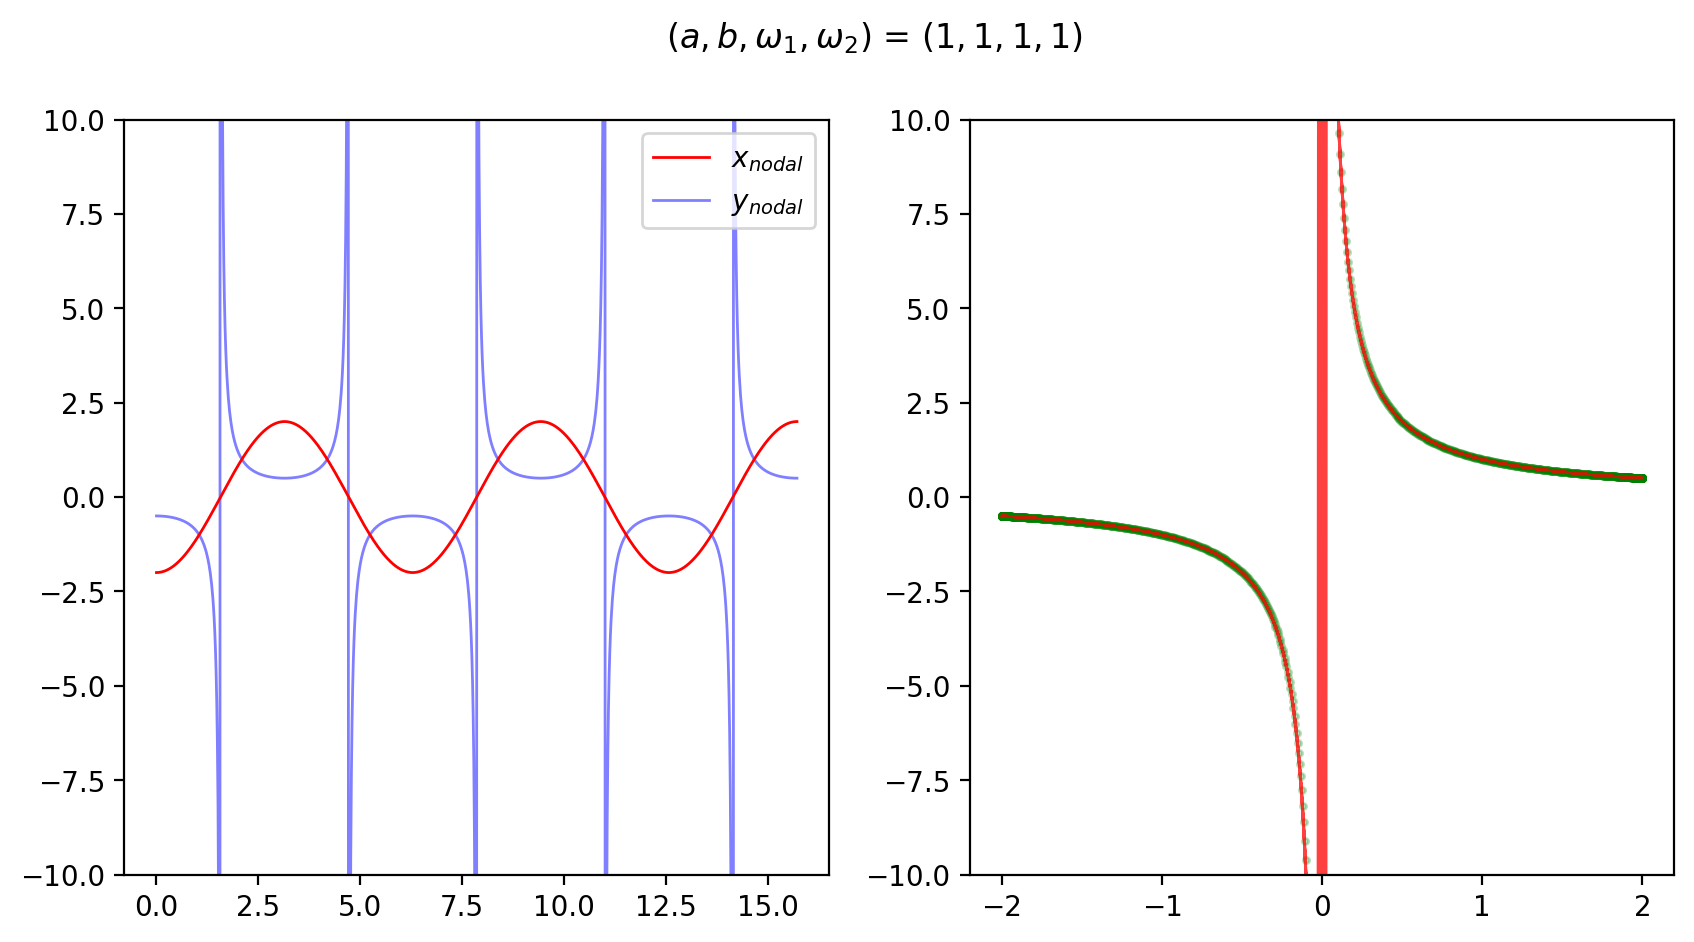

In [7]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5),dpi=200)

ax1.plot(t, x_nodal,c="red",lw=1,label="$x_{nodal}$",alpha=1)
ax1.plot(t, y_nodal,c="blue",lw=1,label="$y_{nodal}$",alpha=0.5,zorder=-10)
ax1.set_ylim(-10,10)
ax1.legend()

ax2.scatter(x_nodal, y_nodal,c="green",s=5,alpha=0.25)
ax2.plot(x_nodal, y_nodal,c="red",lw=1,alpha=0.75)
ax2.set_ylim(-10,10)

suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+str(omega2)+"$)"
fig.suptitle(suptitle)

plt.show()

### Nodal lines: 3D plot

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


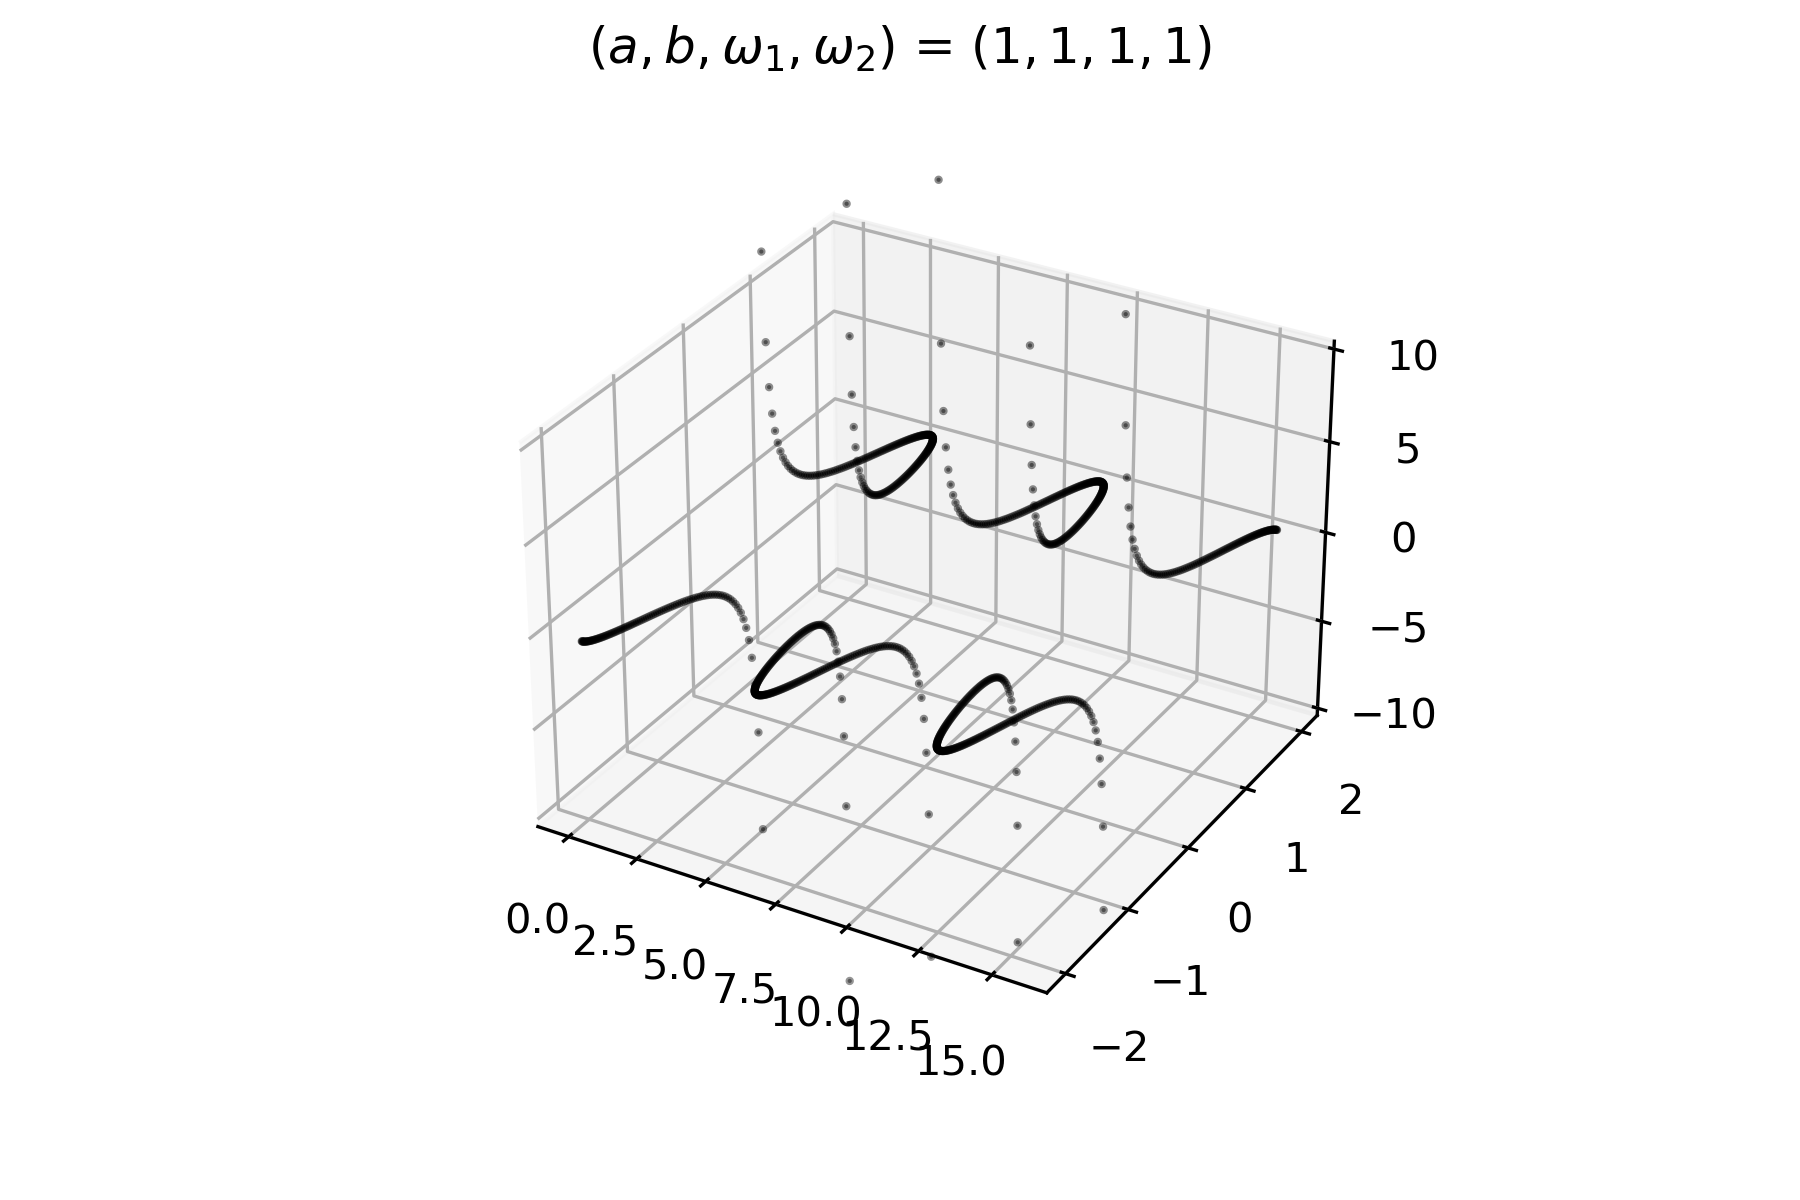

In [9]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

# ax.plot(t, x_nodal, y_nodal, color="black", lw=1)
ax.scatter(t, x_nodal, y_nodal, color="black", s=1)
ax.set_zlim(-10,10)

suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+str(omega2)+"$)"
fig.suptitle(suptitle)

plt.show()

In [10]:
%matplotlib inline

### Lagrangian Descriptor (LD2)

Initial conditions points from regular grid in $XY$ plane

In [18]:
x_min,x_max,Nx = [-4, 4, 600]
y_min,y_max,Ny = [-4, 4, 600]

x_axis = np.linspace(x_min,x_max,Nx)
y_axis = np.linspace(y_min,y_max,Ny)

X,Y = np.meshgrid(x_axis,y_axis)

points = np.column_stack([X.ravel(), Y.ravel()])

Vector field definition

In [19]:
a, b, omega2, t0 = [1, 1, 1, 0]
f = lambda t, u_flat: Bohmian_velocity_field(t, u_flat.reshape(-1,2), PARAMETERS=[a, b, omega2, t0]).flatten()

Solve initial value problem

In [20]:
x0 = points.flatten()
solution = solve_ivp(f, t_span, points.flatten())

Compute and store trajectory arclength values

In [21]:
compute_arclength = lambda trajectory: np.sum(np.linalg.norm(np.gradient(np.array(trajectory).T,axis=0),axis=1))

In [22]:
data_arclength = []
for i in range(Nx*Ny):
    #define trajectory tuple entries
    timeline = solution.t
    traj_x = solution.y[::2][i]
    traj_y = solution.y[1::2][i]
    trajectory = (timeline, traj_x, traj_y)
    
    #compute and store arclength into list
    arclength = compute_arclength(trajectory)
    data_arclength.append(arclength)

# Lagrangian Descriptor (LD2) nd-array
LD = np.array(data_arclength).reshape(Nx, Ny)
# LD = (LD - LD.min())/(LD.max() - LD.min())

Plot plain LD map for initial conditions

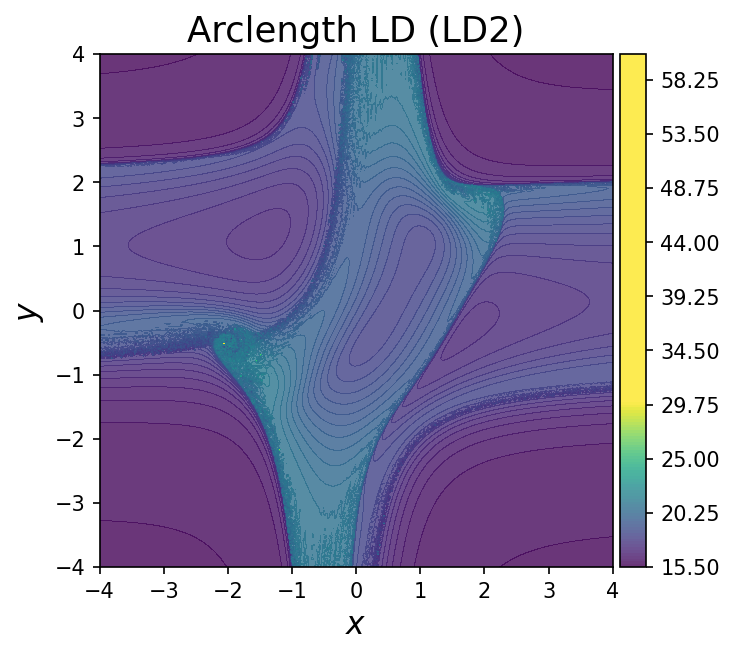

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(1,1,figsize=(5,5),dpi=150,sharex=True, sharey=True)

c = ax.contourf(x_axis, y_axis, LD, 
                cmap="viridis",
                levels=200,
                vmin=15.5,
                vmax=30,
                alpha=0.8,
                zorder=-10
               )

ax.set_title("Arclength LD (LD2)",fontsize=17)
ax.set_xlabel("$x$",fontsize=15)
ax.set_ylabel("$y$",fontsize=15)
ax.set_aspect("equal")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(c, cax=cax)

fig.tight_layout()
plt.show()

### Partition initial conditions via LD laplacian

Compute Laplacian of LD scalar field and mask values below threshold

In [40]:
from scipy.ndimage import laplace
tol = 0.0001
scalar = laplace(LD)
scalar = scalar/scalar.max()
scalar = scalar**2
LD_laplacian = np.ma.masked_where(scalar < tol, scalar )

Image-process the Laplacian values to find the borders between singular and non-singular regions

In [41]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

# Input data
lum = LD_laplacian.data
# tol = 0.0001
tol = 0.00001
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < tol, 600),
    600)

mask = morphology.opening(mask, morphology.disk(3))

Plot bordering curves between singular and non-singular regions

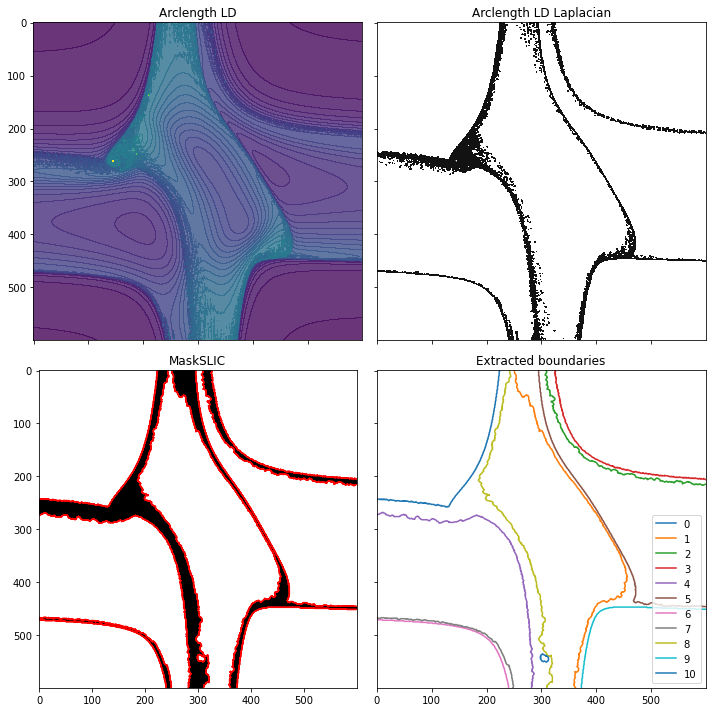

In [44]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))

ax[0][0].contourf(LD,cmap="viridis",levels=200, vmin=15.5, vmax=30,alpha=0.8, zorder=-10)
ax[0][0].set_title("Arclength LD")

ax[0][1].contourf(LD_laplacian, cmap="gray")
ax[0][1].set_title("Arclength LD Laplacian")

ax[1][0].imshow(mask, cmap="gray")
boundaries = ax[1][0].contour(mask, colors='red', linewidths=1)
ax[1][0].set_title("MaskSLIC")

bounding_curves_coords = []
for i in range(len(boundaries.allsegs[0])):
    if len(boundaries.allsegs[0][i]) > 0:
        data = boundaries.allsegs[0][i]
        bounding_curves_coords.append(data)
        ax[1][1].plot(*np.array(data).T, label=str(i))

ax[1][1].set_title("Extracted boundaries")
ax[1][1].legend(loc="best")

plt.tight_layout()
plt.show()

Define polygons from coordinates of bounding curves to define 2D plane regions to select grid points. 

This need some manual selection of the bounding curves to constuct such polygons.

In [45]:
# coupled_bounding_curves_indices = [(3, 6), (1, 7), (4)] #manually inputed
coupled_bounding_curves_indices = [(4, 7), (1, 8), (2, 5)] #manually inputed

In [61]:
plane_subregions = []

Constructure each polygon, verify their shape matches the one in the figure above, and store in a list. 

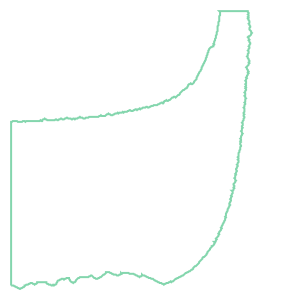

In [62]:
from shapely import geometry
polygon_coordinates = list(bounding_curves_coords[4]) + list(bounding_curves_coords[7])
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

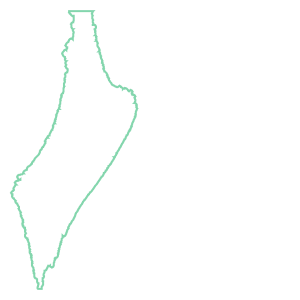

In [63]:
from shapely import geometry
polygon_coordinates = list(bounding_curves_coords[1]) + list(bounding_curves_coords[8])
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

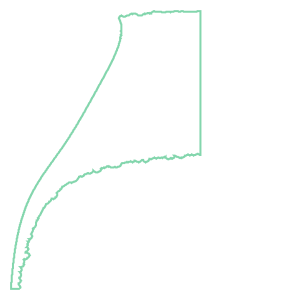

In [64]:
from shapely import geometry
polygon_coordinates = list(bounding_curves_coords[2]) + list(bounding_curves_coords[5])
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

In [65]:
grid_corners = [(0, 0), (0, 600), (600, 600), (600, 0)] #clockwise

In [66]:
# corner_bounding_curves_indices = [0, 5, 8, 2]
corner_bounding_curves_indices = [0, 6, 9, 3]

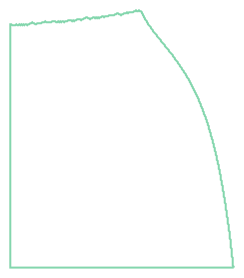

In [67]:
from shapely import geometry
k = 0
curve_index = corner_bounding_curves_indices[k]
polygon_coordinates = list(bounding_curves_coords[curve_index]) + [grid_corners[k]]
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

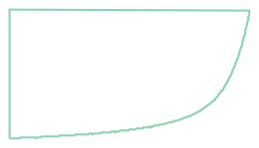

In [68]:
from shapely import geometry
k = 1
curve_index = corner_bounding_curves_indices[k]
polygon_coordinates = list(bounding_curves_coords[curve_index]) + [grid_corners[k]]
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

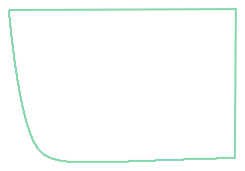

In [69]:
from shapely import geometry
k = 2
curve_index = corner_bounding_curves_indices[k]
polygon_coordinates = list(bounding_curves_coords[curve_index]) + [grid_corners[k]]
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

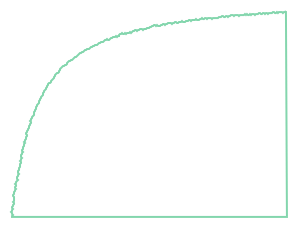

In [70]:
from shapely import geometry
k = 3
curve_index = corner_bounding_curves_indices[k]
polygon_coordinates = list(bounding_curves_coords[curve_index]) + [grid_corners[k]]
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

Gather all polygons, label them, and plot in the plane.

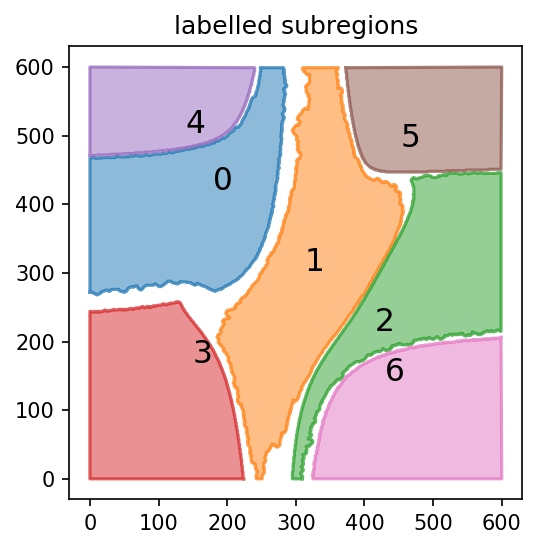

In [90]:
fig,ax = plt.subplots(1,1,dpi=150)

for i in range(len(plane_subregions)):
    subregion_boundary = np.array(plane_subregions[i].exterior.coords)
    ax.fill(*subregion_boundary.T,alpha=0.5)
    ax.plot(*subregion_boundary.T,alpha=0.75)
    ax.text(*np.mean(subregion_boundary.T,axis=1),str(i),fontsize=15)
    
ax.set_title("labelled subregions")
ax.set_aspect('equal')
plt.show()

Filter out gridpoints falling within each labelled subregion

In [91]:
X,Y = np.meshgrid(range(600),range(600))
points = np.column_stack([X.ravel(), Y.ravel()])

In [92]:
from shapely.geometry import Point

Take the subregion 1 as an example

In [93]:
k = 1
points_in_subregion = [plane_subregions[k].contains(Point(*points[i])) for i in range(len(points))]

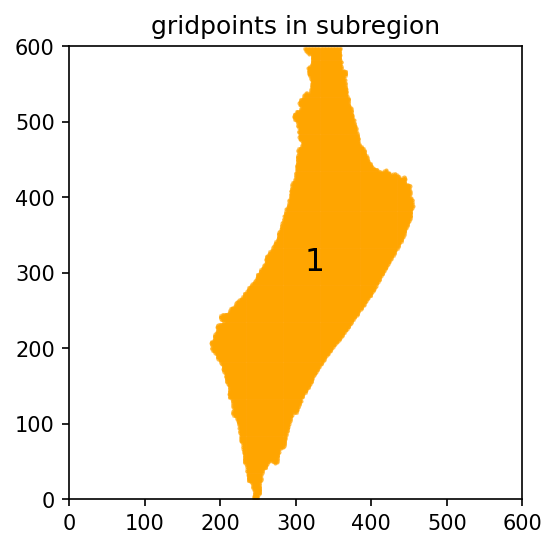

In [95]:
fig,ax = plt.subplots(1,1,dpi=150)

points_filtred = points[points_in_subregion]
ax.scatter(*points_filtred.T,s=0.1,color='orange',alpha=0.5)

subregion_boundary = np.array(plane_subregions[k].exterior.coords)
ax.text(*np.mean(subregion_boundary.T,axis=1),str(k),fontsize=15)

ax.set_xlim(0,600)
ax.set_ylim(0,600)
ax.set_title("gridpoints in subregion")
ax.set_aspect('equal')

plt.show()

In [96]:
trajectories_all = []
for i in range(Nx*Ny):
    timeline = solution.t
    traj_x = solution.y[::2][i]
    traj_y = solution.y[1::2][i]
    trajectory = [timeline, traj_x, traj_y]
    trajectories_all.append(trajectory)

Filtre trajectories associated to intial conditions falling within selected region

In [97]:
from operator import itemgetter

indices = list(np.arange(len(points_in_subregion))[points_in_subregion])
trajectories_subregion = itemgetter(*indices)(trajectories_all)

<IPython.core.display.Javascript object>


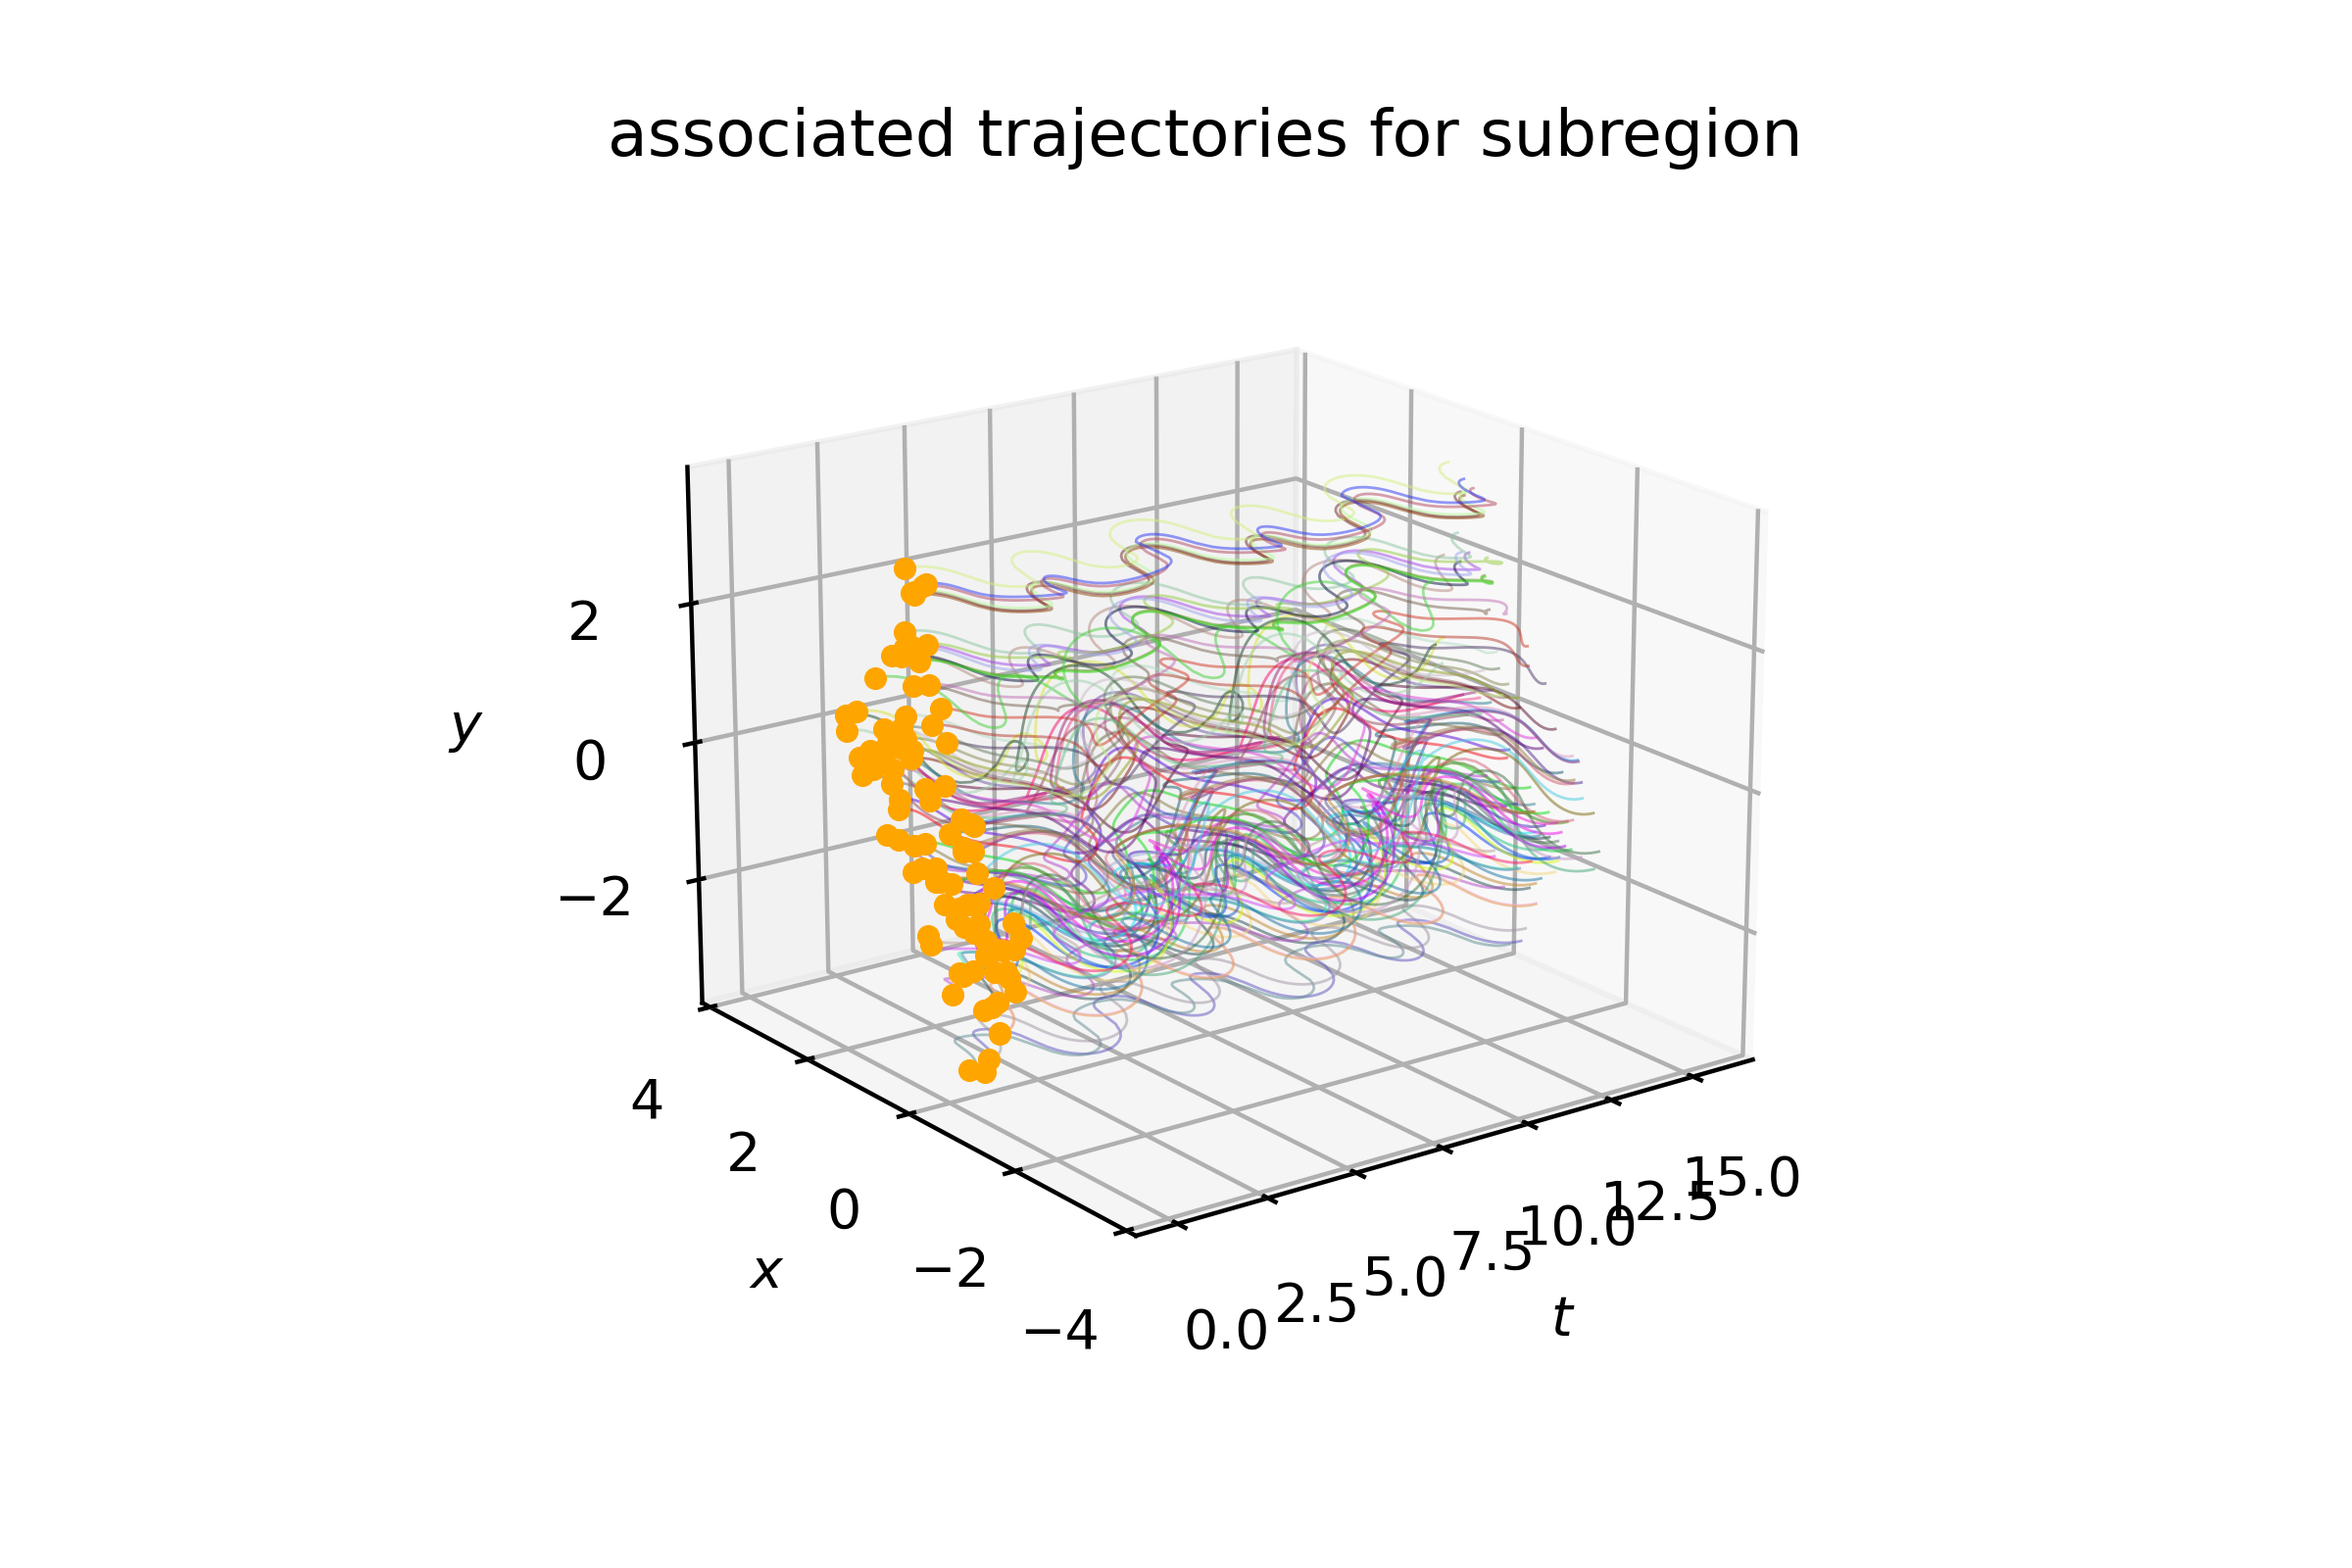

In [98]:
%matplotlib notebook
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

indices_random = np.random.choice(range(len(trajectories_subregion)),100)
for i in indices_random:
    timeline, traj_x, traj_y = trajectories_subregion[i]
    color = np.random.rand(3)
    ax.plot(timeline, traj_x, traj_y, color=color, lw=0.5, alpha=0.5)
    ax.scatter(0, traj_x[0], traj_y[0],s=10,color='orange')
    
ax.set_title("associated trajectories for subregion")
    
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_zlabel("$y$")

# ax.set_ylim(-4,4)
ax.set_ylim(-4,4)

plt.show()

### Volumen renderring from trajectories

Trajctories sampled from selected subregion above (proof of concept)

## Example 2: $(1, 1, 1, 1/\sqrt{2}) = (a, b, \omega_1, \omega_2)$

### Nodal lines: 2D plot

In [100]:
import numpy as np
import matplotlib.pyplot as plt

In [101]:
a, b, omega1, omega2 = (1, 1, 1, 1/np.sqrt(2))

In [102]:
t_span = (0.0001, 4*np.pi/omega2); Nt = 1000
t = np.linspace(*t_span, Nt)

In [103]:
x_nodal = -np.sin(t*(omega1+omega2))/(a*np.sqrt(omega1)*np.sin(omega2*t))
y_nodal = -a*np.sin(omega1*t)/(b*np.sqrt(omega2)*np.sin(t*(omega1+omega2)))

<IPython.core.display.Javascript object>


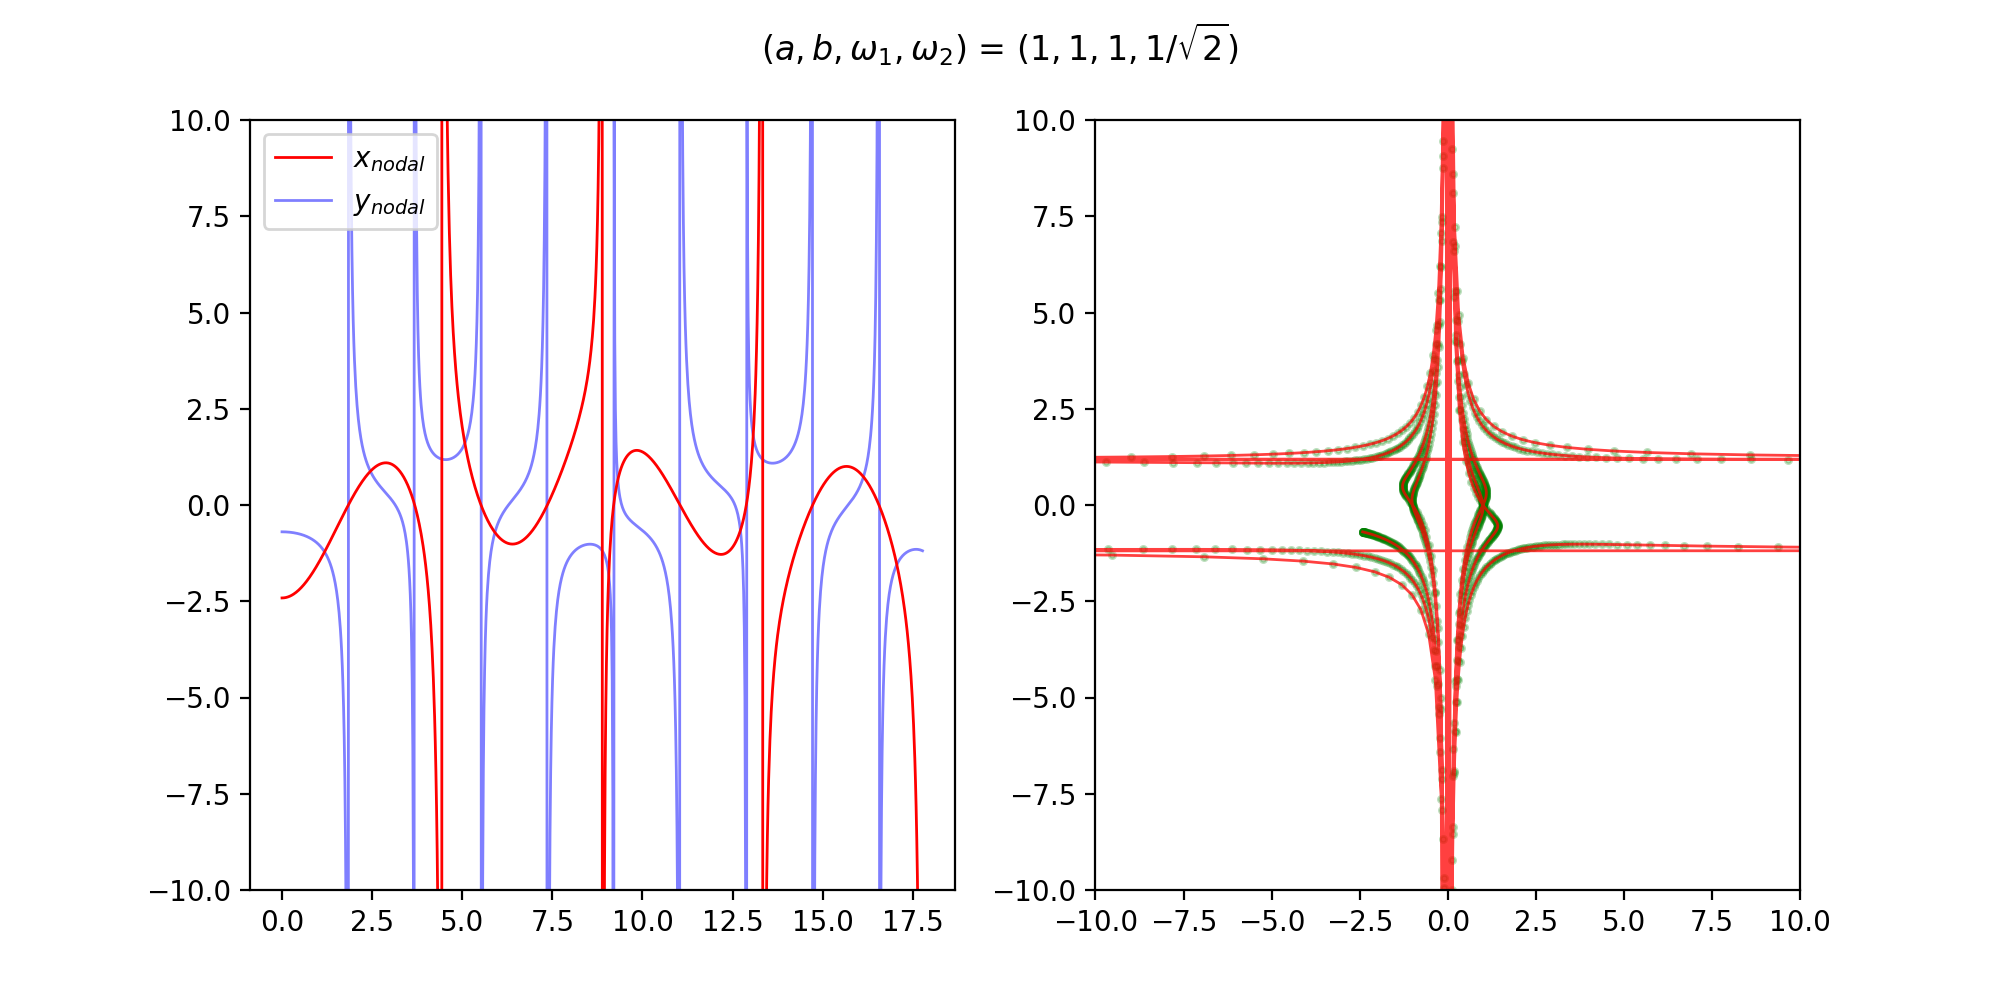

In [104]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5),dpi=200)

ax1.plot(t, x_nodal,c="red",lw=1,label="$x_{nodal}$",alpha=1)
ax1.plot(t, y_nodal,c="blue",lw=1,label="$y_{nodal}$",alpha=0.5,zorder=-10)
ax1.set_ylim(-10,10)
ax1.legend()

ax2.scatter(x_nodal, y_nodal,c="green",s=5,alpha=0.25)
ax2.plot(x_nodal, y_nodal,c="red",lw=1,alpha=0.75)

ax2.set_ylim(-10,10)
ax2.set_xlim(-10,10)

suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+"1/\sqrt{2}"+"$)"
fig.suptitle(suptitle)

plt.show()

### Nodal lines: 3D plot

In [105]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


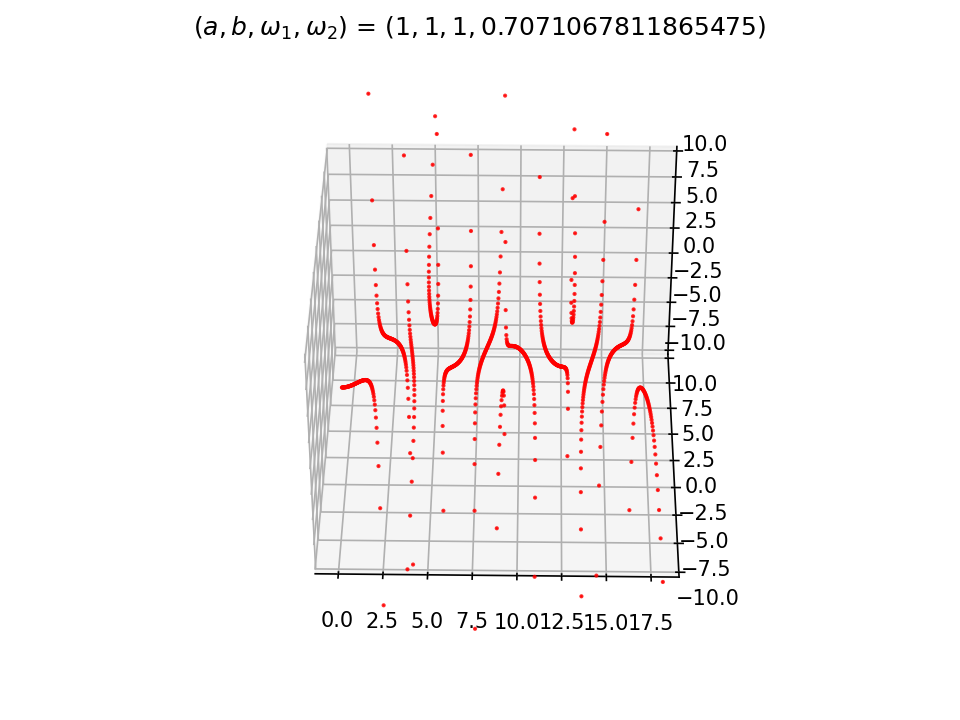

In [108]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

# ax.plot(t, x_nodal, y_nodal, color="green", lw=1)
ax.scatter(t, x_nodal, y_nodal, color="red", s=1)

ax.set_zlim(-10,10)
ax.set_ylim(-10,10)

suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+str(omega2)+"$)"
fig.suptitle(suptitle)

plt.show()

### Lagragian Descriptor

Common input parameters

In [114]:
# Integration parameters
tau = 4*np.pi/omega2

# LDp, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [-6, 6]
y_min,y_max = [-6, 6]
Nx, Ny = [300, 300]

grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
box_boundaries = False

Compute and plot LDs for four resonant cases

In [115]:
x = np.linspace(x_min,x_max,Nx)
y = np.linspace(y_min,y_max,Ny)

a, b, omega2, t0 = [1, 1, 1/np.sqrt(2), 0]
vector_field = lambda t, u: Bohmian_velocity_field(t, u, PARAMETERS=[a, b, omega2, t0])

# compute total LD
LD_forward = compute_lagrangian_descriptor(grid_parameters,vector_field,tau,p_value,box_boundaries)
LD = LD_forward

<IPython.core.display.Javascript object>


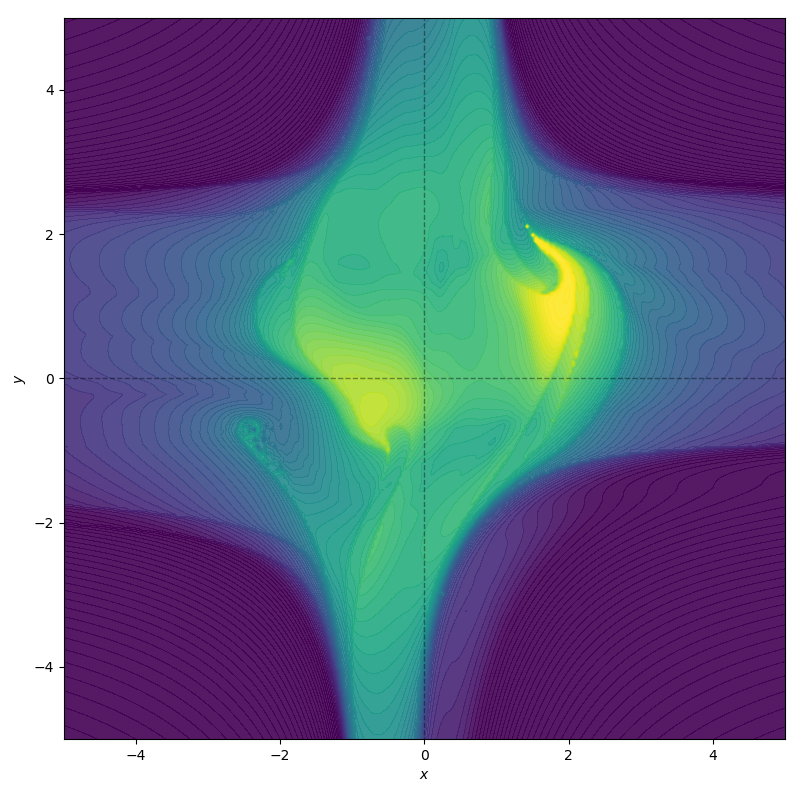

In [116]:
fig,ax = plt.subplots(1,1,figsize=(8,8),dpi=100,sharex=True, sharey=True)

c = ax.contourf(x, y, LD, cmap="viridis",levels=100, vmin=10,vmax=21,alpha=0.9)

#reference lines
ax.plot([-6,6],[0,0],color="black",linestyle="--",lw=1,alpha=0.4)
ax.plot([0,0],[-6,6],color="black",linestyle="--",lw=1,alpha=0.4)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_aspect("equal")
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

fig.tight_layout()
plt.show()

## Resonant cases

### Case $(\omega_1, \omega_2) = (1, k^+)$

<IPython.core.display.Javascript object>


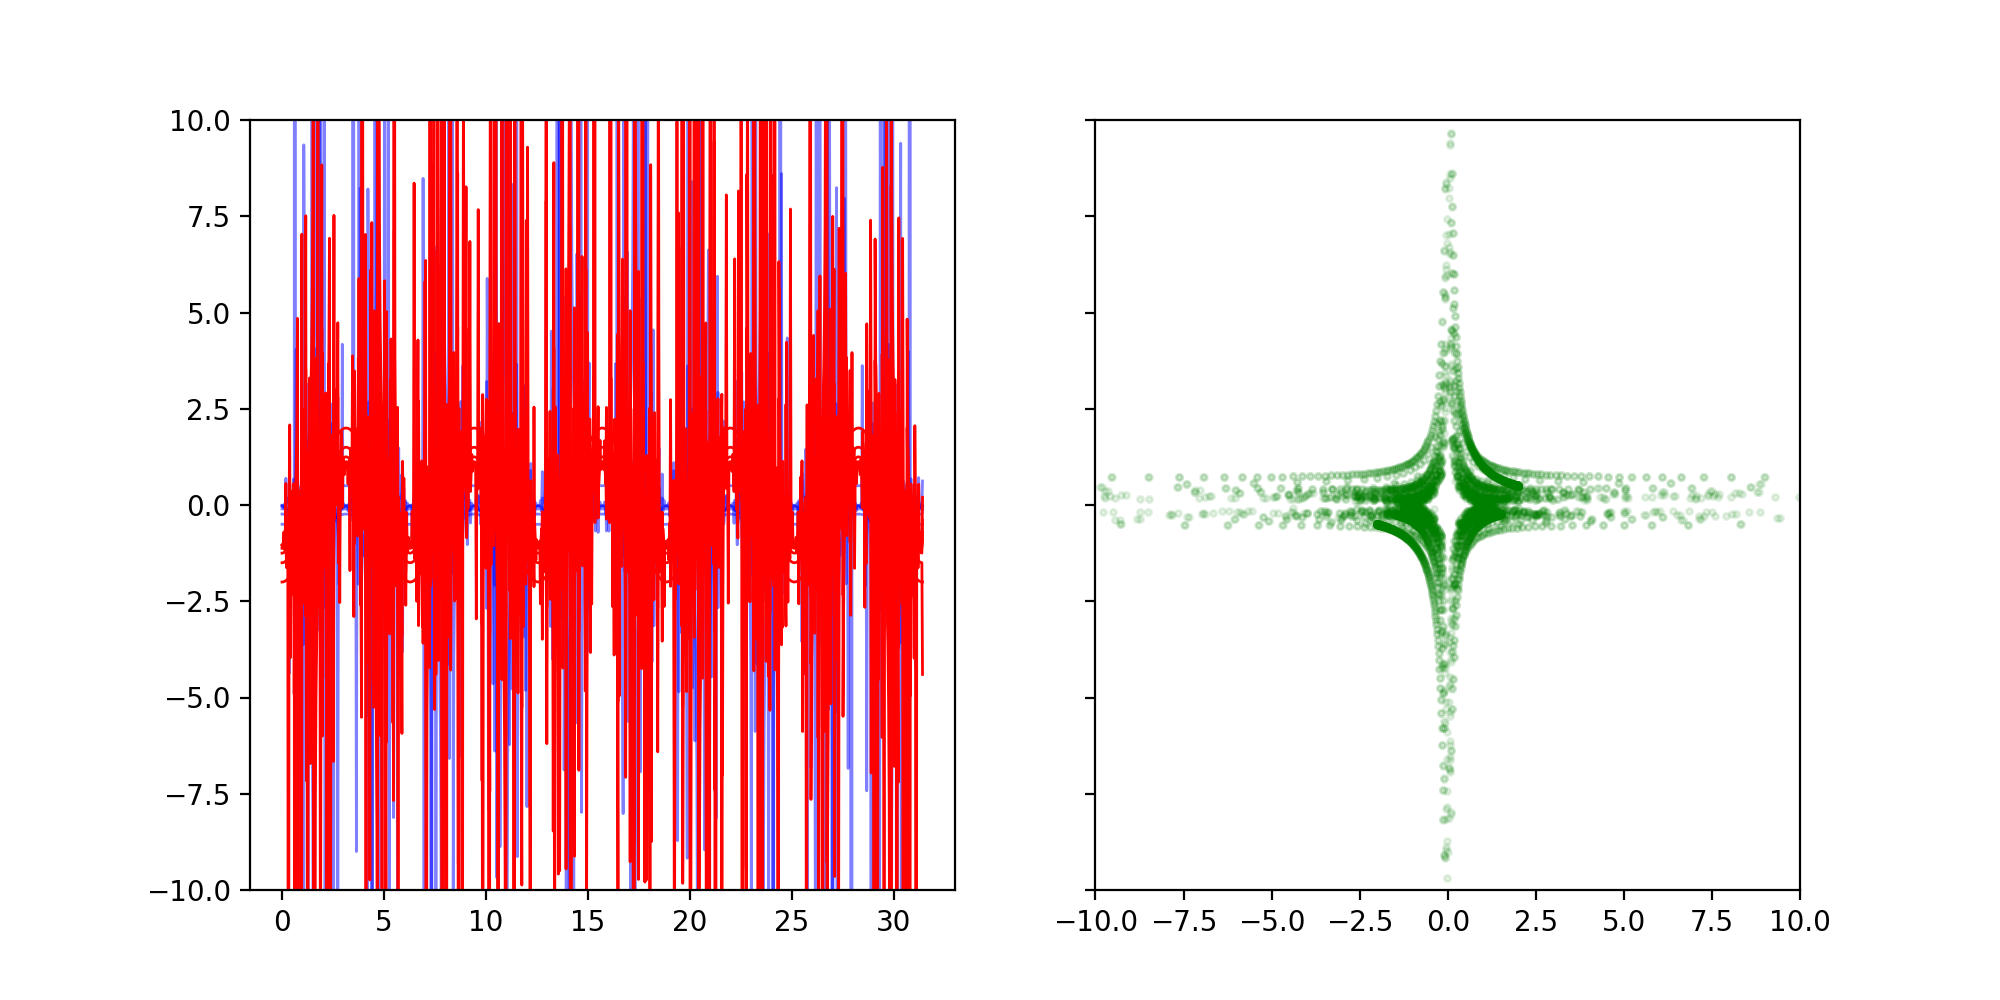

In [44]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5),sharey=True,dpi=200)

for omega2 in [1, 2, 4, 8, 16, 30]:

#     a, b, omega2 = (1, 1, 1/np.sqrt(2))
    a, b, omega1 = (1, 1, 1)

    # t_span = (0.0001, 10*np.pi/omega2); Nt = 1000
    t_span = (0.0001, 10*np.pi); Nt = 1000
    t = np.linspace(*t_span, Nt)

    x_nodal = -np.sin(t*(omega1+omega2))/(a*np.sqrt(omega1)*np.sin(omega2*t))
    y_nodal = -a*np.sin(omega1*t)/(b*np.sqrt(omega2)*np.sin(t*(omega1+omega2)))

    

    ax1.plot(t, x_nodal,c="red",lw=1,label="$x_{nodal}$",alpha=1)
    ax1.plot(t, y_nodal,c="blue",lw=1,label="$y_{nodal}$",alpha=0.5,zorder=-10)
    
#     ax1.legend()

    ax2.scatter(x_nodal, y_nodal,c="green",s=5,alpha=0.1)
#     ax2.plot(x_nodal, y_nodal,c="black",lw=1,alpha=0.1)

ax1.set_ylim(-10,10)
ax2.set_xlim(-10,10)

# suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+str(omega2)+"$)"
# fig.suptitle(suptitle)

plt.show()

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


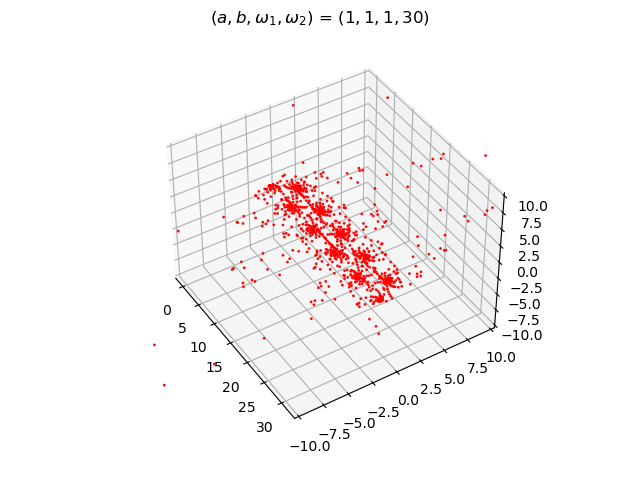

In [46]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')

# ax.plot(t, x_nodal, y_nodal, color="green", lw=1)
ax.scatter(t, x_nodal, y_nodal, color="red", s=1)

ax.set_zlim(-10,10)
ax.set_ylim(-10,10)

suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+str(omega2)+"$)"
fig.suptitle(suptitle)

plt.show()

### Case $(\omega_1, \omega_2) = (k^+, 1)$

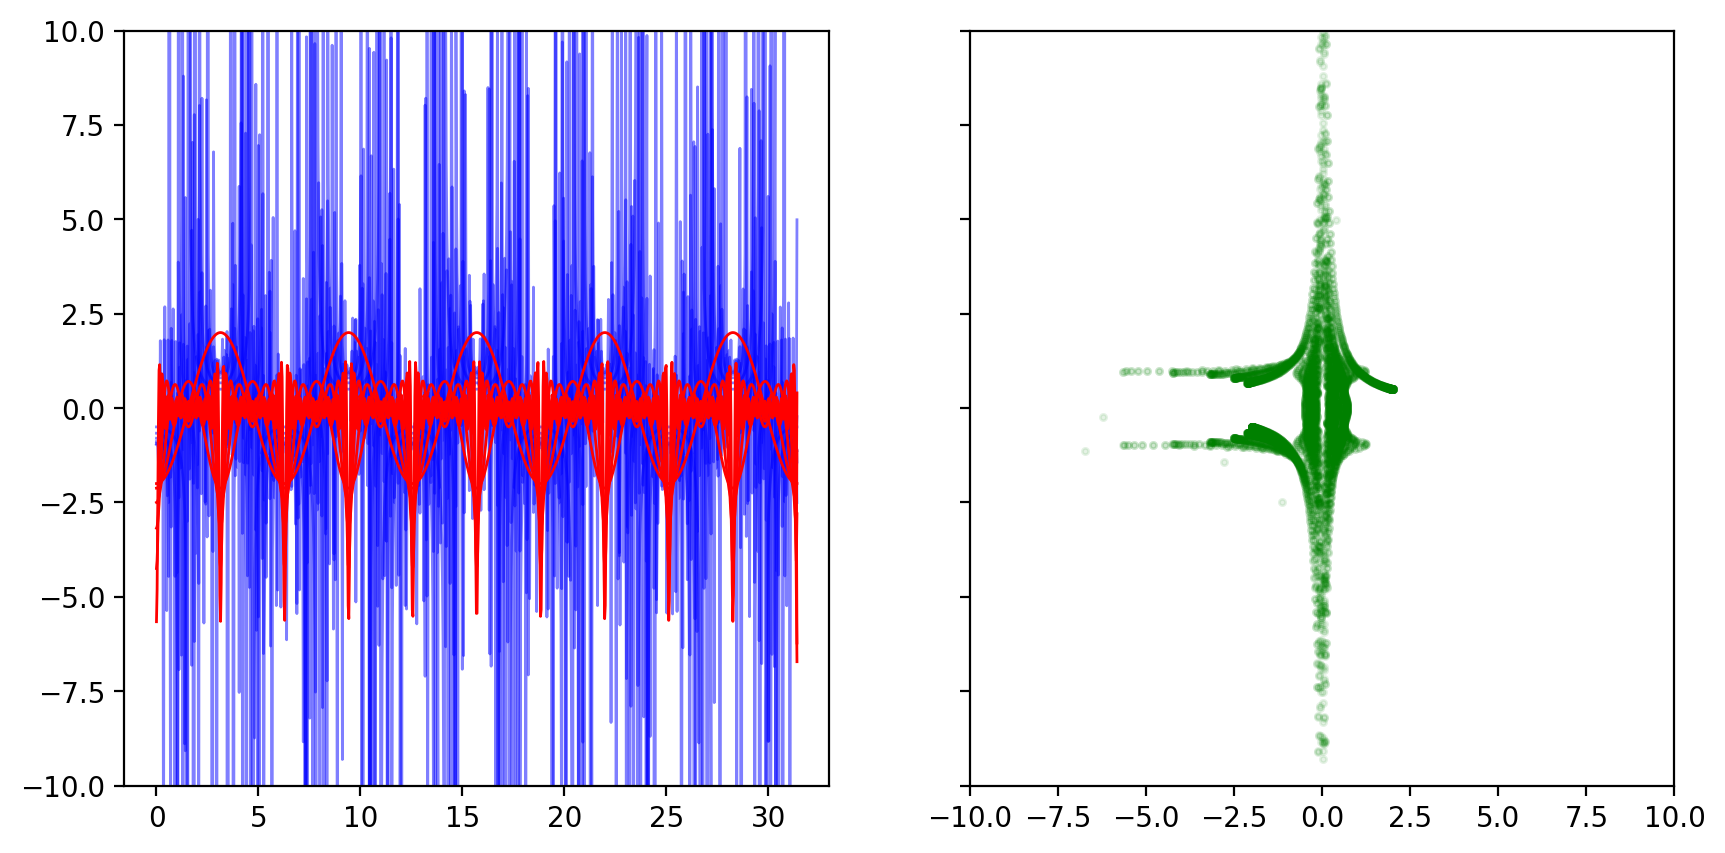

In [102]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5),sharey=True,dpi=200)

for omega1 in [1, 2, 4, 8, 16, 30]:

#     a, b, omega2 = (1, 1, 1/np.sqrt(2))
    a, b, omega2 = (1, 1, 1)

    # t_span = (0.0001, 10*np.pi/omega2); Nt = 1000
    t_span = (0.0001, 10*np.pi); Nt = 1000
    t = np.linspace(*t_span, Nt)

    x_nodal = -np.sin(t*(omega1+omega2))/(a*np.sqrt(omega1)*np.sin(omega2*t))
    y_nodal = -a*np.sin(omega1*t)/(b*np.sqrt(omega2)*np.sin(t*(omega1+omega2)))

    

    ax1.plot(t, x_nodal,c="red",lw=1,label="$x_{nodal}$",alpha=1)
    ax1.plot(t, y_nodal,c="blue",lw=1,label="$y_{nodal}$",alpha=0.5,zorder=-10)
    
#     ax1.legend()

    ax2.scatter(x_nodal, y_nodal,c="green",s=5,alpha=0.1)
#     ax2.plot(x_nodal, y_nodal,c="black",lw=1,alpha=0.1)

ax1.set_ylim(-10,10)
ax2.set_xlim(-10,10)

# suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+str(omega2)+"$)"
# fig.suptitle(suptitle)

plt.show()

## Non-resonant cases

### Case $(\omega_1, \omega_2) = (1/\sqrt{2}, k^+)$

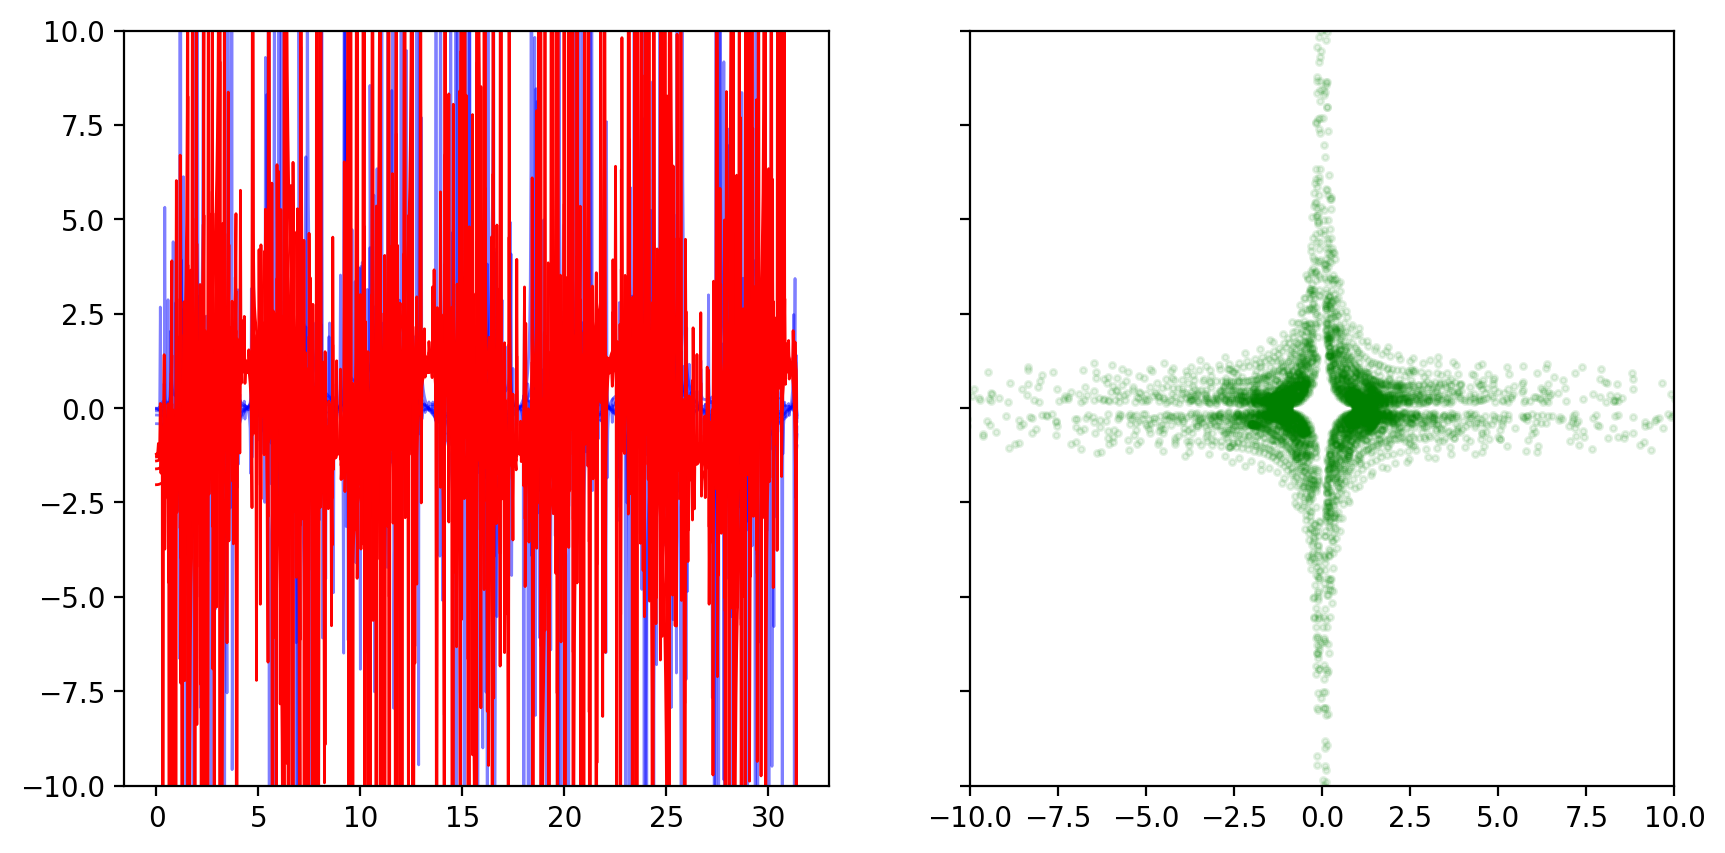

In [99]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5),sharey=True,dpi=200)

for omega2 in [1, 2, 4, 8, 16, 30]:

    a, b, omega1 = (1, 1, 1/np.sqrt(2))

    # t_span = (0.0001, 10*np.pi/omega2); Nt = 1000
    t_span = (0.0001, 10*np.pi); Nt = 1000
    t = np.linspace(*t_span, Nt)

    x_nodal = -np.sin(t*(omega1+omega2))/(a*np.sqrt(omega1)*np.sin(omega2*t))
    y_nodal = -a*np.sin(omega1*t)/(b*np.sqrt(omega2)*np.sin(t*(omega1+omega2)))

    

    ax1.plot(t, x_nodal,c="red",lw=1,label="$x_{nodal}$",alpha=1)
    ax1.plot(t, y_nodal,c="blue",lw=1,label="$y_{nodal}$",alpha=0.5,zorder=-10)
    
#     ax1.legend()

    ax2.scatter(x_nodal, y_nodal,c="green",s=5,alpha=0.1)
#     ax2.plot(x_nodal, y_nodal,c="black",lw=1,alpha=0.1)

ax1.set_ylim(-10,10)
ax2.set_xlim(-10,10)

# suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+str(omega2)+"$)"
# fig.suptitle(suptitle)

plt.show()

### Case $(\omega_1, \omega_2) = (k^+, 1/\sqrt{2})$

<IPython.core.display.Javascript object>


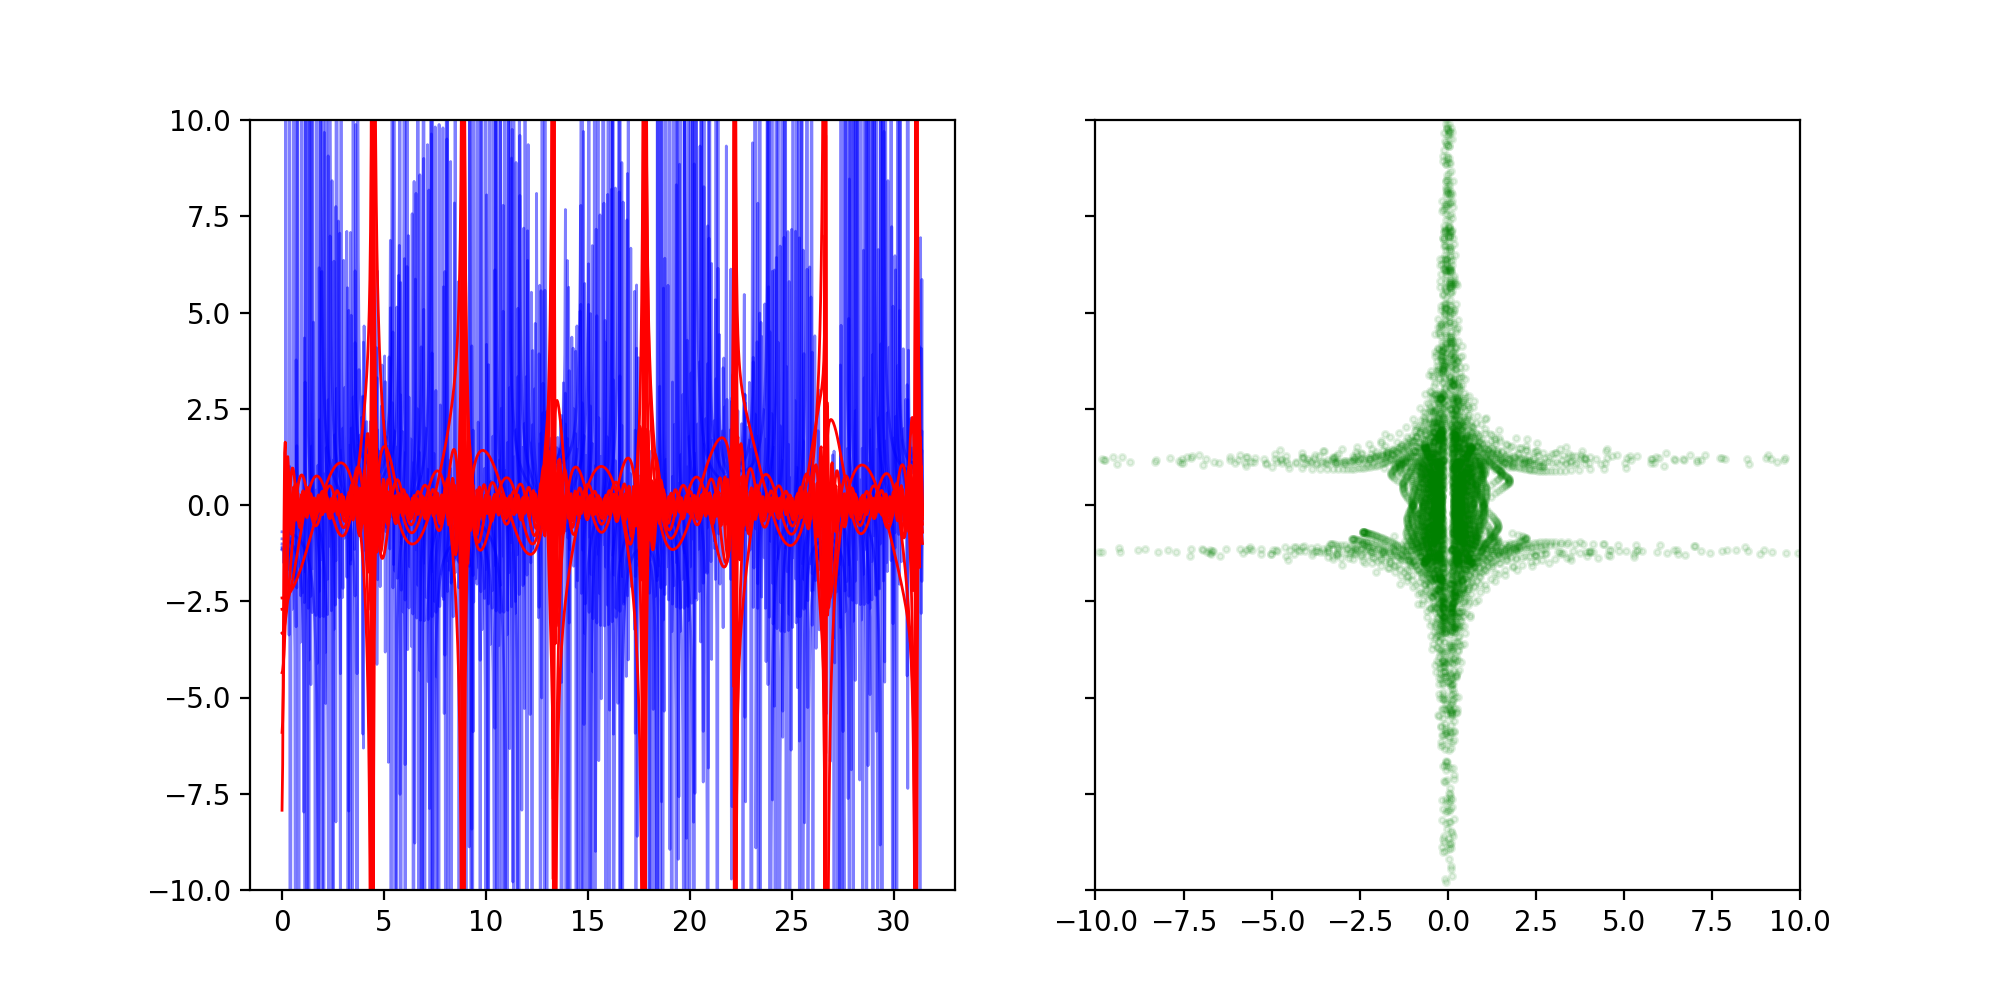

In [47]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5),sharey=True,dpi=200)

for omega1 in [1, 2, 4, 8, 16, 30]:

    a, b, omega2 = (1, 1, 1/np.sqrt(2))

    # t_span = (0.0001, 10*np.pi/omega2); Nt = 1000
    t_span = (0.0001, 10*np.pi); Nt = 1000
    t = np.linspace(*t_span, Nt)

    x_nodal = -np.sin(t*(omega1+omega2))/(a*np.sqrt(omega1)*np.sin(omega2*t))
    y_nodal = -a*np.sin(omega1*t)/(b*np.sqrt(omega2)*np.sin(t*(omega1+omega2)))

    

    ax1.plot(t, x_nodal,c="red",lw=1,label="$x_{nodal}$",alpha=1)
    ax1.plot(t, y_nodal,c="blue",lw=1,label="$y_{nodal}$",alpha=0.5,zorder=-10)
    
#     ax1.legend()

    ax2.scatter(x_nodal, y_nodal,c="green",s=5,alpha=0.1)
#     ax2.plot(x_nodal, y_nodal,c="black",lw=1,alpha=0.1)

ax1.set_ylim(-10,10)
ax2.set_xlim(-10,10)

# suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+str(omega2)+"$)"
# fig.suptitle(suptitle)

plt.show()

<IPython.core.display.Javascript object>


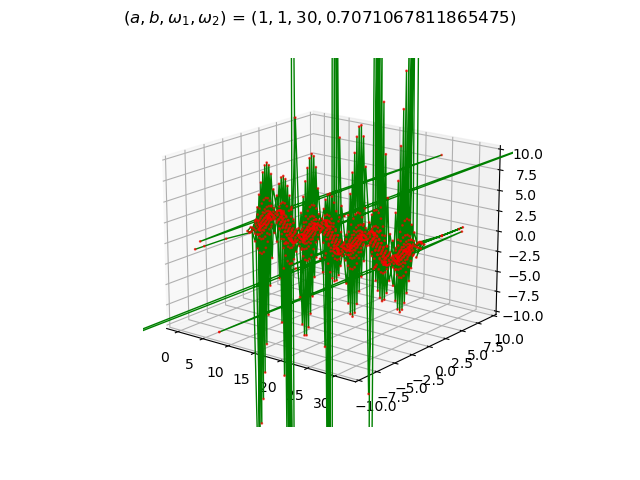

In [48]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')

ax.plot(t, x_nodal, y_nodal, color="green", lw=1)
ax.scatter(t, x_nodal, y_nodal, color="red", s=1)

ax.set_zlim(-10,10)
ax.set_ylim(-10,10)

suptitle = "($a, b, \omega_1, \omega_2$) = ($"+str(a)+", "+str(b)+", "+str(omega1)+","+str(omega2)+"$)"
fig.suptitle(suptitle)

plt.show()

# LD singular curves

Tutorial

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_mask_slic.html#sphx-glr-auto-examples-segmentation-plot-mask-slic-py

In [34]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

# Input data
lum = LDm.data
# tol = 0.0001
tol = 0.00001
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < tol, 600),
    600)

mask = morphology.opening(mask, morphology.disk(3))

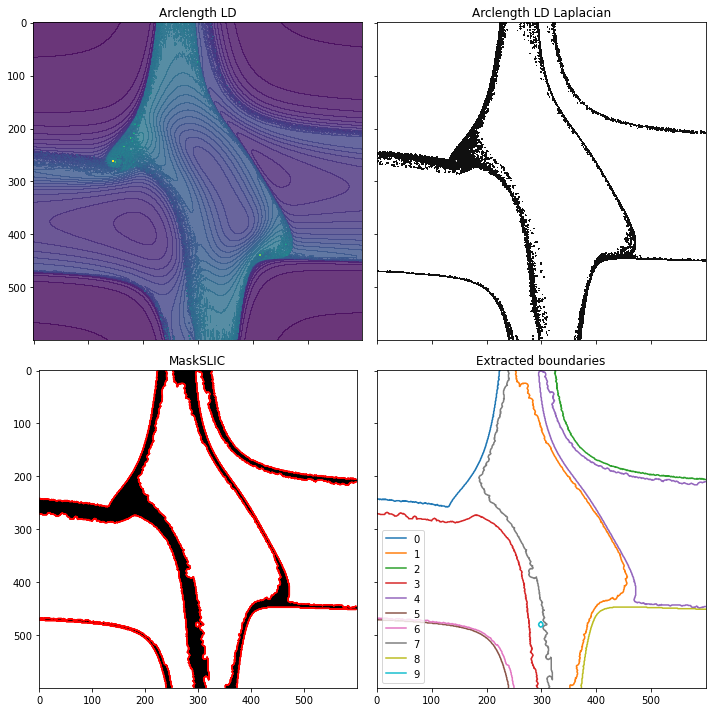

In [38]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))

ax[0][0].contourf(lds.reshape(Nx, Ny), cmap="viridis",levels=200, vmin=15.5, vmax=30,alpha=0.8, zorder=-10)
ax[0][0].set_title("Arclength LD")

ax[0][1].contourf(LDm, cmap="gray")
ax[0][1].set_title("Arclength LD Laplacian")

ax[1][0].imshow(mask, cmap="gray")
boundaries = ax[1][0].contour(mask, colors='red', linewidths=1)
ax[1][0].set_title("MaskSLIC")

bounding_curves_coords = []
for i in range(len(boundaries.allsegs[0])):
    if len(boundaries.allsegs[0][i]) > 0:
        data = boundaries.allsegs[0][i]
        bounding_curves_coords.append(data)
        ax[1][1].plot(*np.array(data).T, label=str(i))

ax[1][1].set_title("Extracted boundaries")
ax[1][1].legend(loc="best")

plt.tight_layout()
plt.show()

In [59]:
coupled_bounding_curves_indices = [(3, 6), (1, 7), (4)] #manually inputed

In [100]:
plane_subregions = []

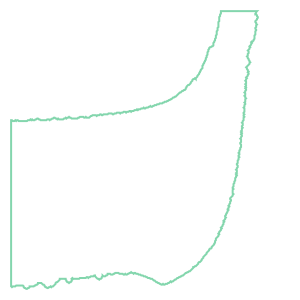

In [101]:
from shapely import geometry
polygon_coordinates = list(bounding_curves_coords[3]) + list(bounding_curves_coords[6])
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

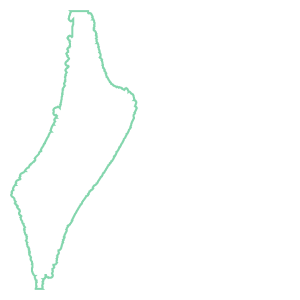

In [102]:
from shapely import geometry
polygon_coordinates = list(bounding_curves_coords[7]) + list(bounding_curves_coords[1])
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

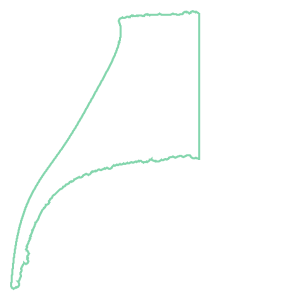

In [103]:
from shapely import geometry
polygon_coordinates = list(bounding_curves_coords[4])
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

In [84]:
grid_corners = [(0, 0), (0, 600), (600, 600), (600, 0)] #clockwise

In [85]:
corner_bounding_curves_indices = [0, 5, 8, 2]

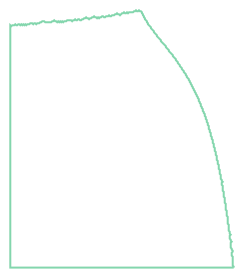

In [104]:
from shapely import geometry
k = 0
curve_index = corner_bounding_curves_indices[k]
polygon_coordinates = list(bounding_curves_coords[curve_index]) + [grid_corners[k]]
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

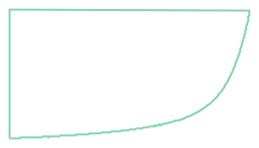

In [105]:
from shapely import geometry
k = 1
curve_index = corner_bounding_curves_indices[k]
polygon_coordinates = list(bounding_curves_coords[curve_index]) + [grid_corners[k]]
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

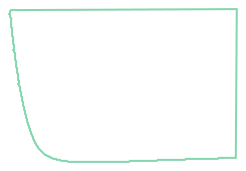

In [106]:
from shapely import geometry
k = 2
curve_index = corner_bounding_curves_indices[k]
polygon_coordinates = list(bounding_curves_coords[curve_index]) + [grid_corners[k]]
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

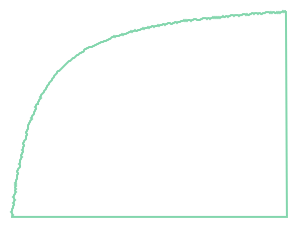

In [107]:
from shapely import geometry
k = 3
curve_index = corner_bounding_curves_indices[k]
polygon_coordinates = list(bounding_curves_coords[curve_index]) + [grid_corners[k]]
polygon = geometry.Polygon([p for p in list(polygon_coordinates)])
polygon = polygon.buffer(0)
plane_subregions.append(polygon)
polygon.boundary

Gather all polygons

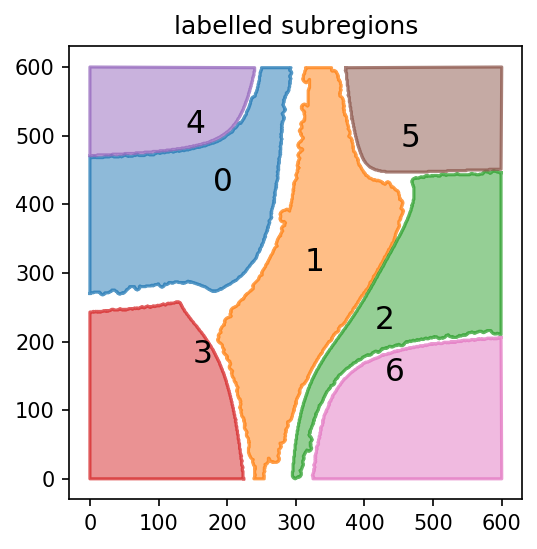

In [130]:
fig,ax = plt.subplots(1,1,dpi=150)

for i in range(len(plane_subregions)):
    subregion_boundary = np.array(plane_subregions[i].boundary.coords)
    ax.fill(*subregion_boundary.T,alpha=0.5)
    ax.plot(*subregion_boundary.T,alpha=0.75)
    ax.text(*np.mean(subregion_boundary.T,axis=1),str(i),fontsize=15)
    
ax.set_title("labelled subregions")
ax.set_aspect('equal')
plt.show()

Filter out gridpoints falling within each labelled subregion

In [135]:
X,Y = np.meshgrid(range(600),range(600))
points = np.column_stack([X.ravel(), Y.ravel()])

In [161]:
k = 1
points_in_subregion = [plane_subregions[k].contains(Point(*points[i])) for i in range(len(points))]

<IPython.core.display.Javascript object>


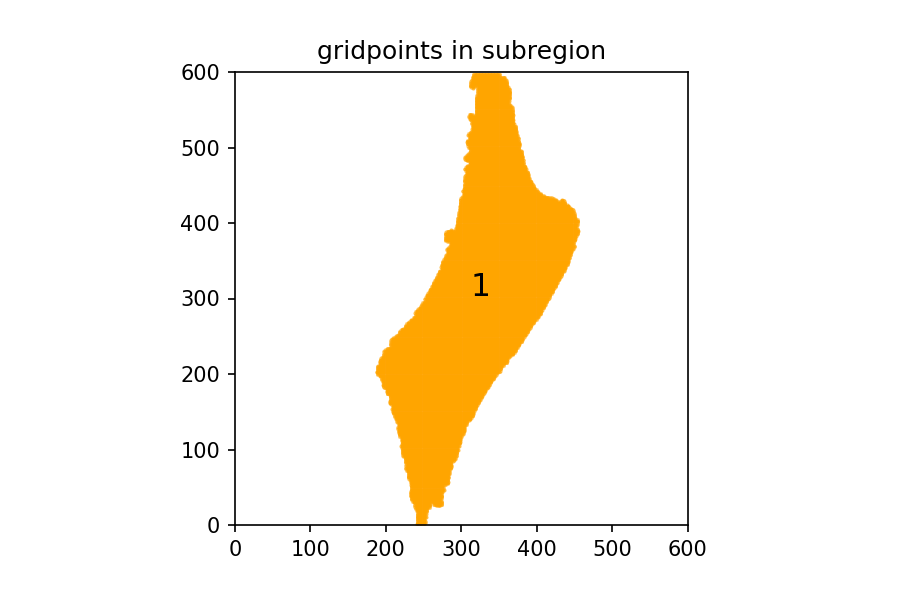

In [239]:
fig,ax = plt.subplots(1,1,dpi=150)

points_filtred = points[points_in_subregion]
ax.scatter(*points_filtred.T,s=0.1,color='orange',alpha=0.5)

subregion_boundary = np.array(plane_subregions[k].boundary.coords)
ax.text(*np.mean(subregion_boundary.T,axis=1),str(k),fontsize=15)

ax.set_xlim(0,600)
ax.set_ylim(0,600)
ax.set_title("gridpoints in subregion")
ax.set_aspect('equal')

plt.show()

In [177]:
trajectories_all = []
for i in range(Nx*Ny):
    timeline = solution.t
    traj_x = solution.y[::2][i]
    traj_y = solution.y[1::2][i]
    trajectory = [timeline, traj_x, traj_y]
    trajectories_all.append(trajectory)

Filtre trajectories associated to intial conditions falling within selected region

In [185]:
from operator import itemgetter

indices = list(np.arange(len(points_in_subregion))[points_in_subregion])
trajectories_subregion = itemgetter(*indices)(trajectories_all)

<IPython.core.display.Javascript object>


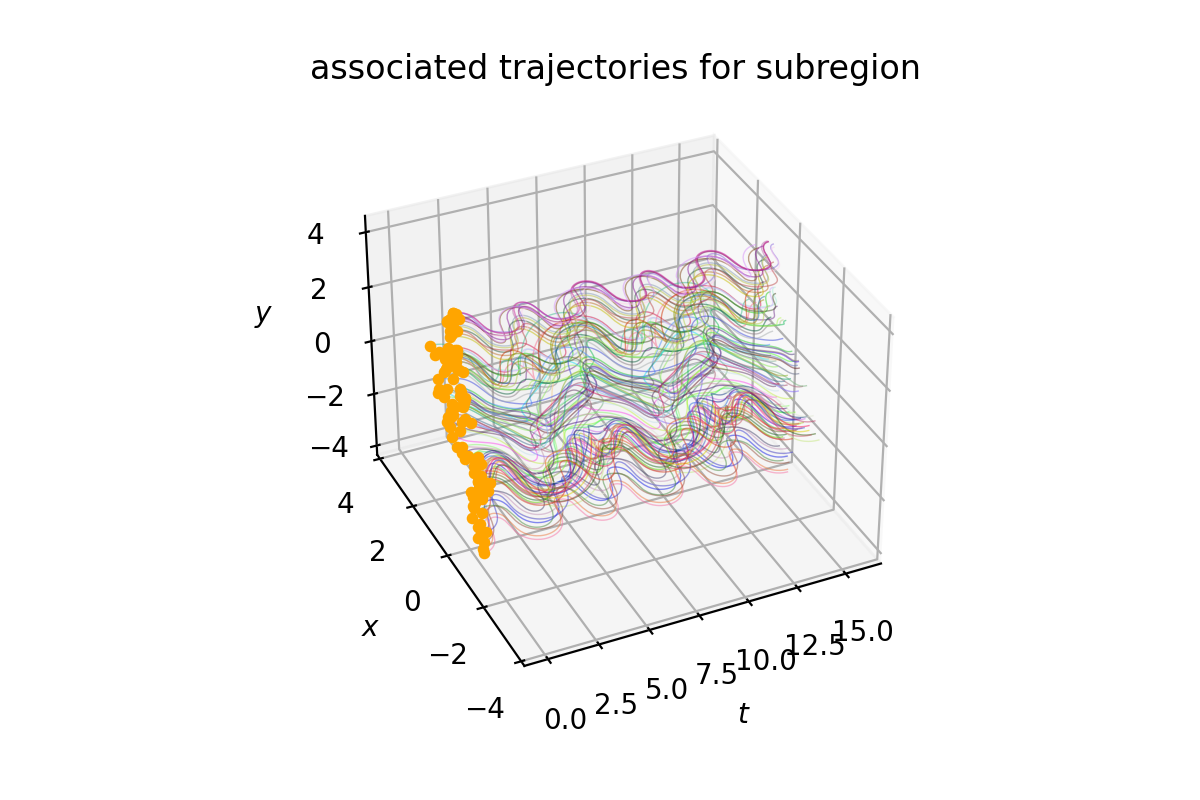

In [238]:
%matplotlib notebook
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

indices_random = np.random.choice(range(len(trajectories_subregion)),100)
for i in indices_random:
    timeline, traj_x, traj_y = trajectories_subregion[i]
    color = np.random.rand(3)
    ax.plot(timeline, traj_x, traj_y, color=color, lw=0.5, alpha=0.5)
    ax.scatter(0, traj_x[0], traj_y[0],s=10,color='orange')
    
ax.set_title("associated trajectories for subregion")
    
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_zlabel("$y$")

# ax.set_ylim(-4,4)
ax.set_ylim(-4,4)

plt.show()

# Appendix

## Lagragian Descriptor

Common input parameters

In [404]:
# Integration parameters
# tau = np.pi
tau = 10*np.pi/2

# LDp, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [-6, 6]
y_min,y_max = [-6, 6]
Nx, Ny = [300, 300]

# for plotting
axis_x = np.linspace(x_min,x_max,Nx)
axis_y = np.linspace(y_min,y_max,Ny)
X, Y = np.meshgrid(axis_x, axis_y)

grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
box_boundaries = False

Compute and plot LDs for four resonant cases

In [405]:
a, b, omega2, t0 = [1, 1, 1, 0]
vector_field = lambda t, u: Bohmian_velocity_field(t, u, PARAMETERS=[a, b, omega2, t0])

# compute total LD
LD_forward = compute_lagrangian_descriptor(grid_parameters,vector_field,tau,p_value,box_boundaries)
LD = LD_forward

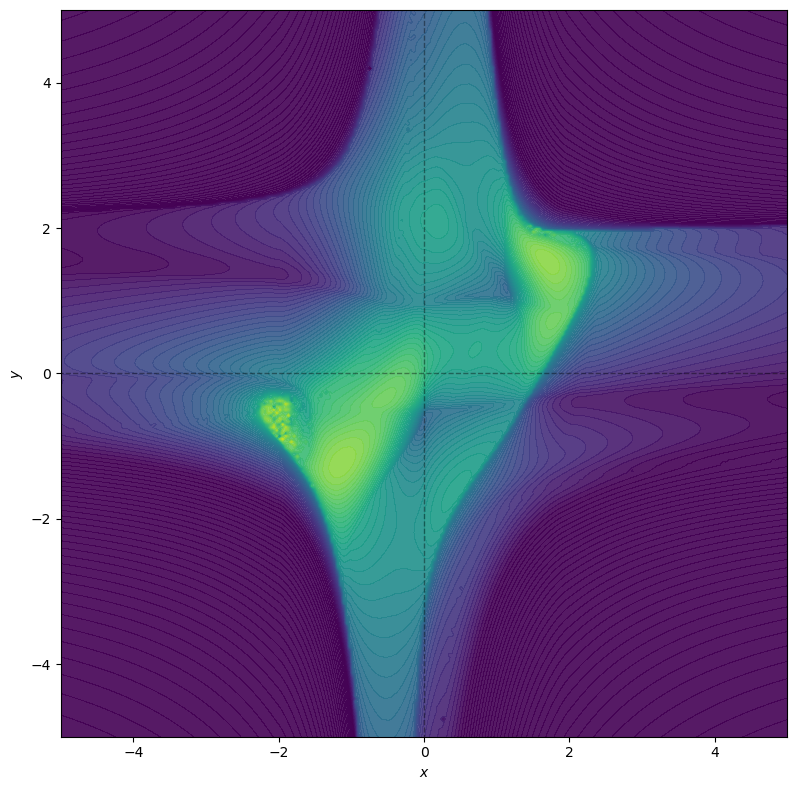

In [406]:
fig,ax = plt.subplots(1,1,figsize=(8,8),dpi=100,sharex=True, sharey=True)

c = ax.contourf(axis_x, axis_x, LD, cmap="viridis",levels=100, vmin=10,vmax=21,alpha=0.9)

#     # plot nodal lines: right branch
#     x_nodal = np.linspace(0.05, 6, 100); y_nodal = 1/(np.sqrt(N)*x_nodal)
#     ax.plot(x_nodal, y_nodal, color="black",lw=1.5,)
    
#     # plot nodal lines: left branch 
#     x_nodal = np.linspace(-0.05, -6, 100); y_nodal = 1/(np.sqrt(N)*x_nodal)
#     ax.plot(x_nodal, y_nodal, color="black",lw=1.5)
    
#     # plot invariant straight line
#     x_invariant = np.linspace(0.1,6,300)
#     y_invariant = x_invariant
#     curve = np.column_stack([x_invariant, y_invariant])
#     ax.plot(*curve.T,color="magenta")

#reference lines
ax.plot([-6,6],[0,0],color="black",linestyle="--",lw=1,alpha=0.4)
ax.plot([0,0],[-6,6],color="black",linestyle="--",lw=1,alpha=0.4)

# # Customise appearance
# title = "$\omega_1$ = 1, "+"$\omega_2 = $"+str(N)
# ax.set_title(title)

# if N == 1:
#     label_nodal = "$y_{nodal} = + 1/ x_{nodal}$"
# else:
#     label_nodal = "$y_{nodal} = + 1/ \sqrt{"+str(N)+"} x_{nodal}$"
# ax.plot([],[],color="black",lw=1.5,label=label_nodal)
# ax.legend(loc="lower left", fontsize=8)

# ax.scatter(0.75, 0.25, s=50, color="red", edgecolor="white", zorder=20)
# ax.scatter(-1, -1, s=50,  color="blueviolet", edgecolor="white", zorder=20)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_aspect("equal")
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

fig.colorbar(c)
fig.tight_layout()
plt.show()

Gradient

<IPython.core.display.Javascript object>


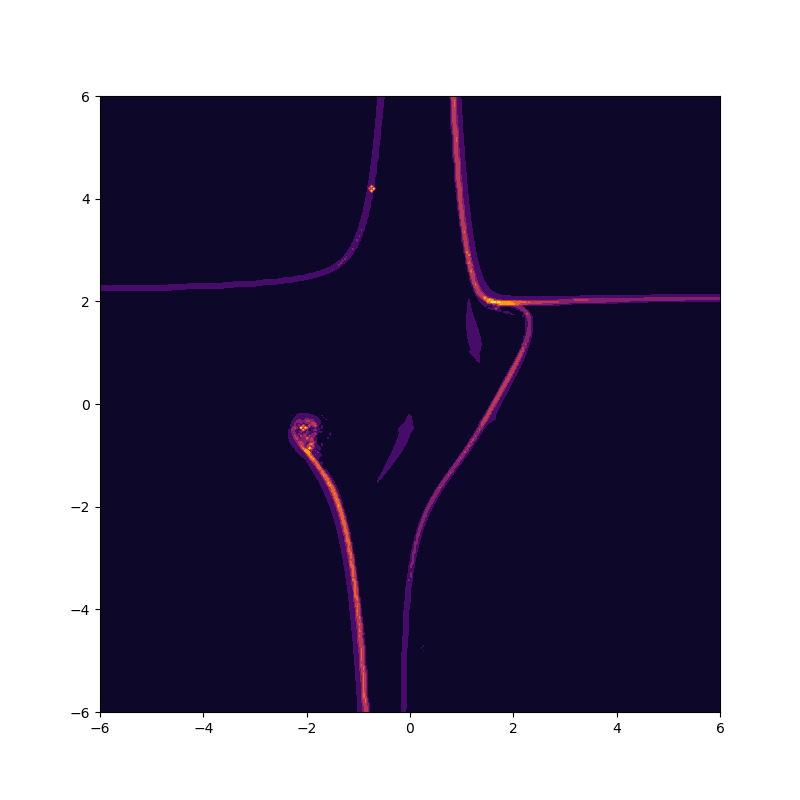

In [431]:
from scipy.ndimage import laplace
from ldds.tools import get_gradient_magnitude

fig,ax = plt.subplots(1,1,figsize=(8,8),dpi=100,sharex=True, sharey=True)

tol = 0.01
#compute laplacian
LD = LD_forward
# scalar = laplace(LD)
# scalar = scalar/scalar.max()
# scalar = scalar**2
# LDm = np.ma.masked_where(scalar < tol, scalar )

LD_gradient = get_gradient_magnitude(LD)

# ax.pcolor(X, Y, LDm, cmap='bwr')
ax.contourf(axis_x, axis_y, LD_gradient, cmap='inferno')
# ax.pcolor(X,Y, LD_gradient, cmap='bwr')

plt.show()

Overlaied version

<IPython.core.display.Javascript object>


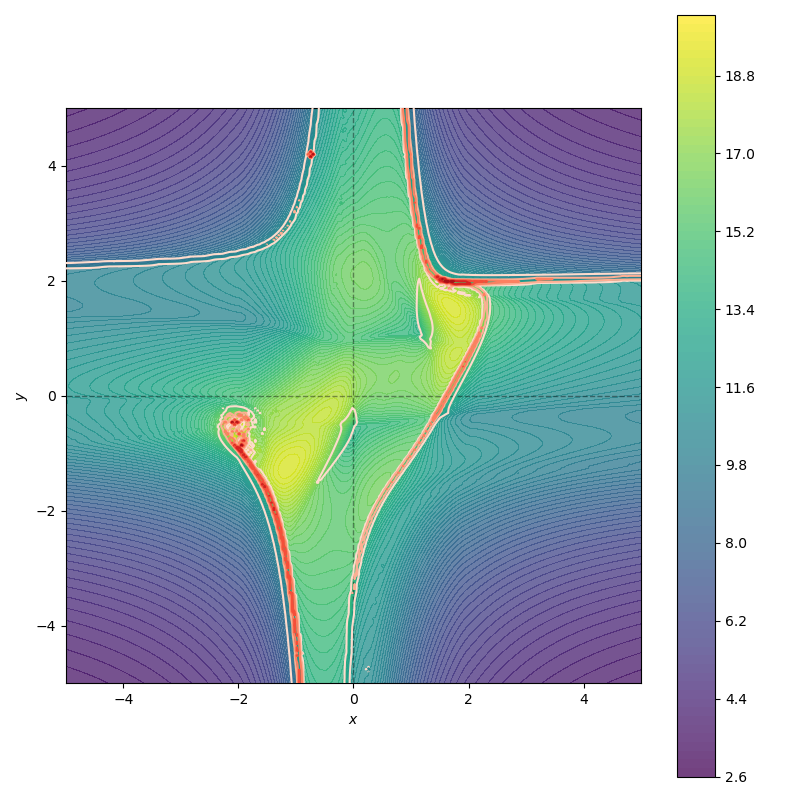

In [433]:
fig,ax = plt.subplots(1,1,figsize=(8,8),dpi=100,sharex=True, sharey=True)

c = ax.contourf(axis_x, axis_x, LD, cmap="viridis",levels=100, alpha=0.75, zorder=-10)
LD_gradient = get_gradient_magnitude(LD)
# ax.pcolor(X, Y, LDm, cmap='bwr')
ax.contour(axis_x, axis_y, LD_gradient, cmap='Reds', zorder=10)

#reference lines
ax.plot([-6,6],[0,0],color="black",linestyle="--",lw=1,alpha=0.4)
ax.plot([0,0],[-6,6],color="black",linestyle="--",lw=1,alpha=0.4)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_aspect("equal")
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

fig.colorbar(c)

fig.tight_layout()
plt.show()

## Cluttering problem visualizing trajectories in 3D

Integrate trajectories for a regular grid of initial conditions

In [11]:
x_min,x_max,Nx = [-4, 4, 20]
y_min,y_max,Ny = [-4, 4, 20]

x = np.linspace(x_min,x_max,Nx)
y = np.linspace(y_min,y_max,Ny)

X,Y = np.meshgrid(x,y)

points = np.column_stack([X.ravel(), Y.ravel()])

In [12]:
a, b, omega2, t0 = [1, 1, 1, 0]
f = lambda t, u_flat: Bohmian_velocity_field(t, u_flat.reshape(-1,2), PARAMETERS=[a, b, omega2, t0]).flatten()

In [13]:
x0 = points.flatten()
solution = solve_ivp(f, t_span, points.flatten())
trajectory = solution.y
time_line = solution.t

Plot projections of trajectory dataset onto planes $(x, t)$ and $(y,t)$

In [14]:
import matplotlib.cm as cm

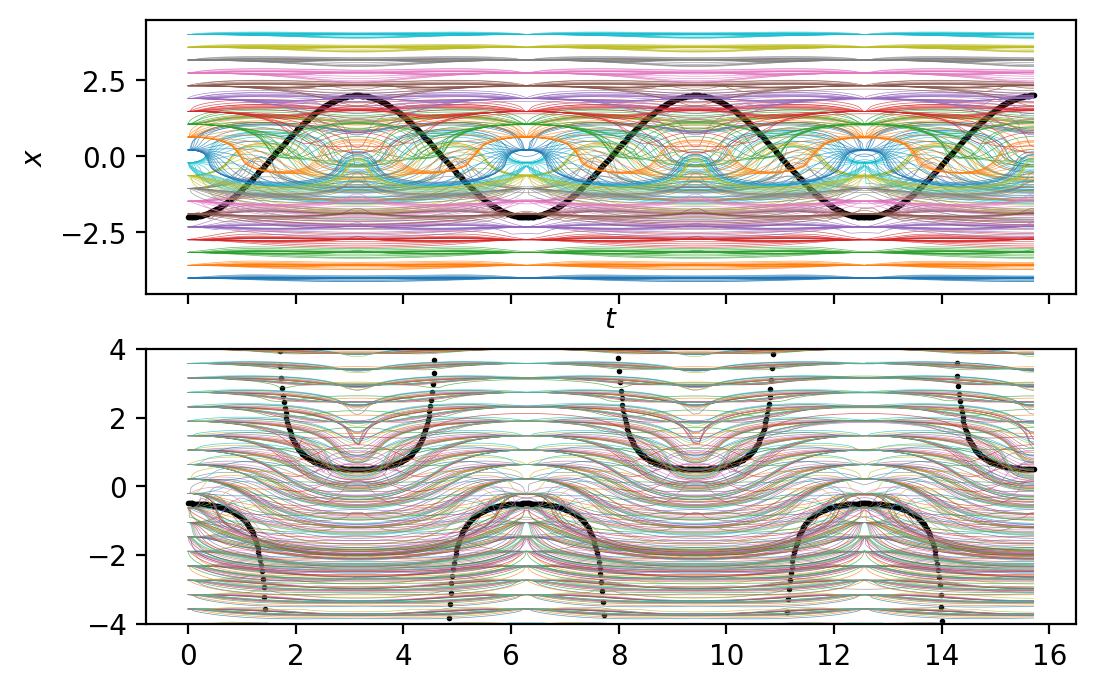

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,dpi=200)

for i in range(Nx*Ny-1):
    ax1.plot(time_line, trajectory[::2][i],lw=0.25, alpha=0.75)
    ax2.plot(time_line, trajectory[1::2][i],lw=0.25, alpha=0.75)
    
# ax.scatter(0, points.T[0], points.T[1], color='blue', s=10)

ax1.scatter(t, x_nodal, color="black", s=1)
ax2.scatter(t, y_nodal, color="black", s=1)

ax1.set_xlabel("$t$")
ax1.set_ylabel("$x$")

ax2.set_ylim(-4,4)

plt.show()

Single trajectories clutter in the 2D planes. 
Note, using same line colours makes things worse. Random colours help a bit to distinguish individual trajectories.

Cluttering cannot be avoided in 3D $(x,y,t)$ either.

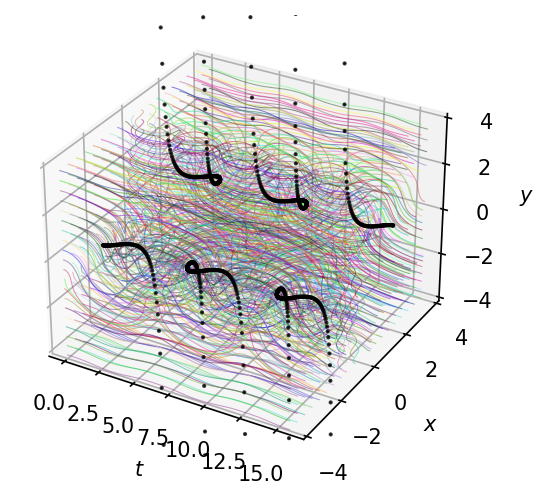

In [16]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

for i in range(Nx*Ny-1):
    ax.plot(time_line, trajectory[::2][i], trajectory[1::2][i], color=np.random.rand(3), lw=0.5, alpha=0.5)
    
# ax.scatter(0, points.T[0], points.T[1], color='blue', s=10)

ax.scatter(t, x_nodal, y_nodal, color="black", s=1)
ax.set_zlim(-4,4)

ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_zlabel("$y$")

ax.set_ylim(-4,4)

plt.show()

We also tried to colour 3D trajectories according to their arclength.
There's a minor improvement but cluttering is still being a issue as trajectories at the back of the visualization plane remain hiden. 

In [17]:
%matplotlib inline

In [18]:
compute_arclength = lambda trajectory: np.sum(np.linalg.norm(np.gradient(np.array(trajectory).T,axis=0),axis=1))

In [19]:
TRAJECTORIES_arclength = []
for i in range(Nx*Ny):
    timeline = solution.t
    traj_x = solution.y[::2][i]
    traj_y = solution.y[1::2][i]
    trajectory = [timeline, traj_x, traj_y]
    arclength = compute_arclength(trajectory)
    TRAJECTORIES_arclength.append(arclength)

In [20]:
lds = np.array(TRAJECTORIES_arclength)
lds = (lds - lds.min())/(lds.max() - lds.min())

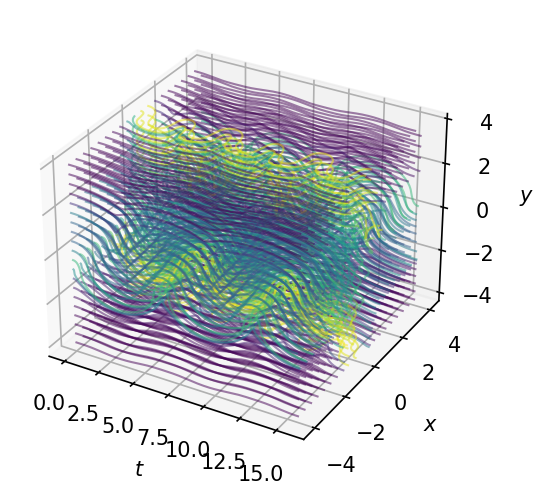

In [21]:
cmap = plt.cm.viridis

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

for i in range(Nx*Ny-1):
    timeline = solution.t
    traj_x = solution.y[::2][i]
    traj_y = solution.y[1::2][i]
    ax.plot(timeline, traj_x, traj_y, c=cmap(lds[i]), lw=1, alpha=0.5)
    
# ax.scatter(t, x_nodal, y_nodal, color="black", s=1)
# ax.set_zlim(-4,4)

ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_zlabel("$y$")

# ax.set_ylim(-4,4)

plt.show()

## Print off mouse click coordinates

This relies on defining a clickin event over a panel generated using a different backend `tk`

In [18]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(20,30))

img=mpimg.imread('ldimage.png')

coords = []
def onclick(event):
    ix, iy = event.xdata, event.ydata
    coords.append((ix, iy))
    print(ix, iy)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

239.6030979642513 23.241993969611542
281.7566955047987 19.842510296986745
188.61084287487935 185.0574167865518
66.90932739491166 178.25844944130222
64.86963719133678 298.60017145222
232.12423388447675 293.8408943105453
265.4391738761997 291.80120410697043
292.63504325719805 293.8408943105453
489.80509626943626 200.69504168062588
489.80509626943626 89.1919772185326
385.1009991525925 96.67084129830715
322.55049957629626 19.162613562461786
491.1648897384862 20.522407031511705
